In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    next_states_logits, Qlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                      action_size=action_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                          action_size=action_size, state_size=state_size, reuse=True)
    #################################################### GAN
    Qlogits = tf.reshape(Qlogits, shape=[-1])
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(nextQlogits) # minimize nextQ
    aloss = -tf.reduce_mean(nextQlogits) # maximize nextQ
    ###################################################### Qlearning
    ###################################################### Q(s,a)= r + Q'(s',a')
    rewards = tf.reduce_mean(tf.square(Qlogits - (gamma * nextQlogits)))
    ##################################################### GAN + DDPG
    eloss += tf.reduce_mean(rewards) # minimize entropy=error
    aloss += -tf.reduce_mean(rewards) # maximize entropy=rewards
    return actions_logits, aloss, eloss, rewards

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.rewards_ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
def minibacth_random(memory, batch_size):
    # Training with the maxrated minibatch
    while True:
        batch = memory.sample(batch_size=batch_size)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        next_states = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        rates = np.array([each[5] for each in batch])
        states = states[rates > 0]
        actions = actions[rates > 0]
        next_states = next_states[rates > 0]
        rewards = rewards[rates > 0]
        dones = dones[rates > 0]
        rates = rates[rates > 0]
        if len(dones) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth_random(memory=memory, 
                                                                                   batch_size=batch_size)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss_batch.append(eloss)
            aloss_batch.append(aloss)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:-0.2414 eloss:4.0268 exploreP:0.9986
Episode:1 meanR:21.5000 R:29.0000 rate:0.0580 aloss:-0.2199 eloss:3.9907 exploreP:0.9958
Episode:2 meanR:26.6667 R:37.0000 rate:0.0740 aloss:-0.1883 eloss:3.9373 exploreP:0.9921
Episode:3 meanR:23.2500 R:13.0000 rate:0.0260 aloss:-0.1646 eloss:3.8975 exploreP:0.9908
Episode:4 meanR:24.0000 R:27.0000 rate:0.0540 aloss:-0.1465 eloss:3.8688 exploreP:0.9882
Episode:5 meanR:23.8333 R:23.0000 rate:0.0460 aloss:-0.1247 eloss:3.8320 exploreP:0.9859
Episode:6 meanR:22.2857 R:13.0000 rate:0.0260 aloss:-0.1085 eloss:3.8042 exploreP:0.9847
Episode:7 meanR:23.5000 R:32.0000 rate:0.0640 aloss:-0.0910 eloss:3.7756 exploreP:0.9816
Episode:8 meanR:22.2222 R:12.0000 rate:0.0240 aloss:-0.0728 eloss:3.7455 exploreP:0.9804
Episode:9 meanR:24.3000 R:43.0000 rate:0.0860 aloss:-0.0512 eloss:3.7100 exploreP:0.9762
Episode:10 meanR:23.2727 R:13.0000 rate:0.0260 aloss:-0.0301 eloss:3.6745 exploreP:0.9750
Episode:11 meanR:25.

Episode:93 meanR:20.3936 R:26.0000 rate:0.0520 aloss:0.3524 eloss:3.0556 exploreP:0.8273
Episode:94 meanR:20.3895 R:20.0000 rate:0.0400 aloss:0.3648 eloss:3.0394 exploreP:0.8257
Episode:95 meanR:20.2604 R:8.0000 rate:0.0160 aloss:0.3674 eloss:3.0346 exploreP:0.8250
Episode:96 meanR:20.1959 R:14.0000 rate:0.0280 aloss:0.3818 eloss:3.0179 exploreP:0.8239
Episode:97 meanR:20.1735 R:18.0000 rate:0.0360 aloss:0.3848 eloss:3.0123 exploreP:0.8224
Episode:98 meanR:20.2020 R:23.0000 rate:0.0460 aloss:0.4046 eloss:2.9895 exploreP:0.8205
Episode:99 meanR:20.0900 R:9.0000 rate:0.0180 aloss:0.4077 eloss:2.9835 exploreP:0.8198
Episode:100 meanR:20.2900 R:34.0000 rate:0.0680 aloss:0.4214 eloss:2.9658 exploreP:0.8171
Episode:101 meanR:20.1700 R:17.0000 rate:0.0340 aloss:0.4373 eloss:2.9451 exploreP:0.8157
Episode:102 meanR:19.9000 R:10.0000 rate:0.0200 aloss:0.4386 eloss:2.9422 exploreP:0.8149
Episode:103 meanR:19.9500 R:18.0000 rate:0.0360 aloss:0.4540 eloss:2.9237 exploreP:0.8134
Episode:104 meanR:1

Episode:185 meanR:17.5300 R:23.0000 rate:0.0460 aloss:1.3986 eloss:1.8276 exploreP:0.7067
Episode:186 meanR:17.8400 R:46.0000 rate:0.0920 aloss:1.4108 eloss:1.8166 exploreP:0.7035
Episode:187 meanR:17.8100 R:14.0000 rate:0.0280 aloss:1.4405 eloss:1.7883 exploreP:0.7026
Episode:188 meanR:17.9600 R:38.0000 rate:0.0760 aloss:1.4507 eloss:1.7791 exploreP:0.6999
Episode:189 meanR:17.9600 R:12.0000 rate:0.0240 aloss:1.4933 eloss:1.7363 exploreP:0.6991
Episode:190 meanR:18.0200 R:16.0000 rate:0.0320 aloss:1.5083 eloss:1.7227 exploreP:0.6980
Episode:191 meanR:17.7400 R:16.0000 rate:0.0320 aloss:1.4935 eloss:1.7405 exploreP:0.6969
Episode:192 meanR:17.7800 R:14.0000 rate:0.0280 aloss:1.5145 eloss:1.7194 exploreP:0.6960
Episode:193 meanR:17.6500 R:13.0000 rate:0.0260 aloss:1.5045 eloss:1.7290 exploreP:0.6951
Episode:194 meanR:17.5500 R:10.0000 rate:0.0200 aloss:1.5280 eloss:1.7075 exploreP:0.6944
Episode:195 meanR:17.6000 R:13.0000 rate:0.0260 aloss:1.5564 eloss:1.6776 exploreP:0.6935
Episode:19

Episode:278 meanR:17.9700 R:10.0000 rate:0.0200 aloss:2.6527 eloss:0.8095 exploreP:0.5988
Episode:279 meanR:17.9700 R:14.0000 rate:0.0280 aloss:2.6799 eloss:0.7855 exploreP:0.5979
Episode:280 meanR:17.9400 R:9.0000 rate:0.0180 aloss:2.7247 eloss:0.7480 exploreP:0.5974
Episode:281 meanR:17.8700 R:13.0000 rate:0.0260 aloss:2.6839 eloss:0.7828 exploreP:0.5966
Episode:282 meanR:17.9800 R:25.0000 rate:0.0500 aloss:2.6621 eloss:0.8126 exploreP:0.5952
Episode:283 meanR:17.9600 R:12.0000 rate:0.0240 aloss:2.6880 eloss:0.7895 exploreP:0.5945
Episode:284 meanR:18.0200 R:22.0000 rate:0.0440 aloss:2.6755 eloss:0.8016 exploreP:0.5932
Episode:285 meanR:18.0400 R:25.0000 rate:0.0500 aloss:2.7068 eloss:0.7722 exploreP:0.5917
Episode:286 meanR:17.6800 R:10.0000 rate:0.0200 aloss:2.7675 eloss:0.7114 exploreP:0.5911
Episode:287 meanR:17.6500 R:11.0000 rate:0.0220 aloss:2.7642 eloss:0.7232 exploreP:0.5905
Episode:288 meanR:17.3700 R:10.0000 rate:0.0200 aloss:2.7092 eloss:0.7816 exploreP:0.5899
Episode:289

Episode:371 meanR:14.3800 R:18.0000 rate:0.0360 aloss:3.3503 eloss:0.2057 exploreP:0.5266
Episode:372 meanR:14.3900 R:13.0000 rate:0.0260 aloss:3.3011 eloss:0.2593 exploreP:0.5259
Episode:373 meanR:14.3200 R:10.0000 rate:0.0200 aloss:3.3827 eloss:0.1800 exploreP:0.5254
Episode:374 meanR:14.0900 R:9.0000 rate:0.0180 aloss:3.4629 eloss:0.1039 exploreP:0.5249
Episode:375 meanR:14.0700 R:11.0000 rate:0.0220 aloss:3.3901 eloss:0.1762 exploreP:0.5244
Episode:376 meanR:13.8000 R:10.0000 rate:0.0200 aloss:3.3425 eloss:0.2179 exploreP:0.5238
Episode:377 meanR:13.8300 R:12.0000 rate:0.0240 aloss:3.3827 eloss:0.1799 exploreP:0.5232
Episode:378 meanR:13.8400 R:11.0000 rate:0.0220 aloss:3.4075 eloss:0.1627 exploreP:0.5227
Episode:379 meanR:13.8400 R:14.0000 rate:0.0280 aloss:3.3560 eloss:0.2092 exploreP:0.5219
Episode:380 meanR:13.8800 R:13.0000 rate:0.0260 aloss:3.4614 eloss:0.1112 exploreP:0.5213
Episode:381 meanR:13.8400 R:9.0000 rate:0.0180 aloss:3.4063 eloss:0.1658 exploreP:0.5208
Episode:382 

Episode:462 meanR:12.3400 R:13.0000 rate:0.0260 aloss:3.7867 eloss:-0.2208 exploreP:0.4724
Episode:463 meanR:12.3100 R:9.0000 rate:0.0180 aloss:3.8017 eloss:-0.2350 exploreP:0.4720
Episode:464 meanR:12.2800 R:9.0000 rate:0.0180 aloss:3.8092 eloss:-0.2432 exploreP:0.4716
Episode:465 meanR:12.3300 R:18.0000 rate:0.0360 aloss:3.8444 eloss:-0.2765 exploreP:0.4707
Episode:466 meanR:12.3100 R:12.0000 rate:0.0240 aloss:3.7946 eloss:-0.2304 exploreP:0.4702
Episode:467 meanR:12.3200 R:15.0000 rate:0.0300 aloss:3.8546 eloss:-0.2895 exploreP:0.4695
Episode:468 meanR:12.2700 R:10.0000 rate:0.0200 aloss:3.8932 eloss:-0.3285 exploreP:0.4690
Episode:469 meanR:12.2900 R:17.0000 rate:0.0340 aloss:3.8444 eloss:-0.2779 exploreP:0.4682
Episode:470 meanR:12.2500 R:9.0000 rate:0.0180 aloss:3.7042 eloss:-0.1416 exploreP:0.4678
Episode:471 meanR:12.2200 R:15.0000 rate:0.0300 aloss:3.8262 eloss:-0.2684 exploreP:0.4671
Episode:472 meanR:12.2300 R:14.0000 rate:0.0280 aloss:3.8084 eloss:-0.2471 exploreP:0.4665
Ep

Episode:554 meanR:12.6400 R:12.0000 rate:0.0240 aloss:4.0352 eloss:-0.6097 exploreP:0.4214
Episode:555 meanR:12.6500 R:9.0000 rate:0.0180 aloss:4.0927 eloss:-0.6677 exploreP:0.4210
Episode:556 meanR:12.6300 R:9.0000 rate:0.0180 aloss:4.0184 eloss:-0.5905 exploreP:0.4206
Episode:557 meanR:12.6400 R:10.0000 rate:0.0200 aloss:4.1716 eloss:-0.7437 exploreP:0.4202
Episode:558 meanR:12.6600 R:13.0000 rate:0.0260 aloss:4.0872 eloss:-0.6654 exploreP:0.4197
Episode:559 meanR:12.7100 R:16.0000 rate:0.0320 aloss:4.0386 eloss:-0.6186 exploreP:0.4190
Episode:560 meanR:12.6000 R:8.0000 rate:0.0160 aloss:3.9404 eloss:-0.5194 exploreP:0.4187
Episode:561 meanR:12.6200 R:15.0000 rate:0.0300 aloss:4.1707 eloss:-0.7465 exploreP:0.4181
Episode:562 meanR:12.5900 R:10.0000 rate:0.0200 aloss:4.0862 eloss:-0.6658 exploreP:0.4177
Episode:563 meanR:12.6500 R:15.0000 rate:0.0300 aloss:4.1057 eloss:-0.6842 exploreP:0.4171
Episode:564 meanR:12.6800 R:12.0000 rate:0.0240 aloss:4.0565 eloss:-0.6332 exploreP:0.4166
Ep

Episode:645 meanR:12.6200 R:15.0000 rate:0.0300 aloss:3.7741 eloss:-0.3132 exploreP:0.3768
Episode:646 meanR:12.6500 R:11.0000 rate:0.0220 aloss:3.8254 eloss:-0.3641 exploreP:0.3764
Episode:647 meanR:12.6000 R:9.0000 rate:0.0180 aloss:3.6596 eloss:-0.1947 exploreP:0.3761
Episode:648 meanR:12.5700 R:9.0000 rate:0.0180 aloss:3.5757 eloss:-0.0999 exploreP:0.3757
Episode:649 meanR:12.5300 R:10.0000 rate:0.0200 aloss:3.5860 eloss:-0.1156 exploreP:0.3754
Episode:650 meanR:12.4800 R:10.0000 rate:0.0200 aloss:3.7282 eloss:-0.2521 exploreP:0.3750
Episode:651 meanR:12.4600 R:11.0000 rate:0.0220 aloss:3.7261 eloss:-0.2488 exploreP:0.3746
Episode:652 meanR:12.4400 R:13.0000 rate:0.0260 aloss:3.7736 eloss:-0.2925 exploreP:0.3741
Episode:653 meanR:12.4200 R:10.0000 rate:0.0200 aloss:3.5899 eloss:-0.1115 exploreP:0.3738
Episode:654 meanR:12.4200 R:12.0000 rate:0.0240 aloss:3.7256 eloss:-0.2393 exploreP:0.3733
Episode:655 meanR:12.4700 R:14.0000 rate:0.0280 aloss:3.7427 eloss:-0.2459 exploreP:0.3728
E

Episode:736 meanR:16.6500 R:21.0000 rate:0.0420 aloss:2.4189 eloss:0.7928 exploreP:0.3238
Episode:737 meanR:17.3100 R:77.0000 rate:0.1540 aloss:2.6644 eloss:0.5365 exploreP:0.3213
Episode:738 meanR:17.6300 R:42.0000 rate:0.0840 aloss:2.9716 eloss:0.2197 exploreP:0.3200
Episode:739 meanR:17.9000 R:43.0000 rate:0.0860 aloss:3.1220 eloss:0.0640 exploreP:0.3187
Episode:740 meanR:18.0800 R:29.0000 rate:0.0580 aloss:3.2248 eloss:-0.0416 exploreP:0.3178
Episode:741 meanR:18.3400 R:35.0000 rate:0.0700 aloss:3.3332 eloss:-0.1526 exploreP:0.3167
Episode:742 meanR:18.5200 R:27.0000 rate:0.0540 aloss:3.4740 eloss:-0.2926 exploreP:0.3159
Episode:743 meanR:18.6300 R:21.0000 rate:0.0420 aloss:3.5387 eloss:-0.3605 exploreP:0.3153
Episode:744 meanR:18.7600 R:25.0000 rate:0.0500 aloss:3.6719 eloss:-0.4888 exploreP:0.3145
Episode:745 meanR:18.8700 R:26.0000 rate:0.0520 aloss:3.6864 eloss:-0.5015 exploreP:0.3137
Episode:746 meanR:19.0800 R:32.0000 rate:0.0640 aloss:3.7556 eloss:-0.5672 exploreP:0.3127
Epi

Episode:827 meanR:32.2100 R:47.0000 rate:0.0940 aloss:4.7874 eloss:-1.5602 exploreP:0.2436
Episode:828 meanR:32.1300 R:20.0000 rate:0.0400 aloss:4.7463 eloss:-1.5164 exploreP:0.2431
Episode:829 meanR:32.4700 R:70.0000 rate:0.1400 aloss:4.6817 eloss:-1.4540 exploreP:0.2415
Episode:830 meanR:32.5100 R:29.0000 rate:0.0580 aloss:4.7752 eloss:-1.5525 exploreP:0.2408
Episode:831 meanR:32.5100 R:32.0000 rate:0.0640 aloss:4.7216 eloss:-1.5012 exploreP:0.2401
Episode:832 meanR:32.4000 R:30.0000 rate:0.0600 aloss:4.6447 eloss:-1.4249 exploreP:0.2394
Episode:833 meanR:32.3600 R:30.0000 rate:0.0600 aloss:4.5881 eloss:-1.3720 exploreP:0.2387
Episode:834 meanR:32.5900 R:38.0000 rate:0.0760 aloss:4.7095 eloss:-1.5002 exploreP:0.2379
Episode:835 meanR:32.8300 R:63.0000 rate:0.1260 aloss:4.6924 eloss:-1.4804 exploreP:0.2364
Episode:836 meanR:33.2100 R:59.0000 rate:0.1180 aloss:4.6476 eloss:-1.4401 exploreP:0.2351
Episode:837 meanR:32.8300 R:39.0000 rate:0.0780 aloss:4.7197 eloss:-1.5129 exploreP:0.2342

Episode:918 meanR:39.1900 R:22.0000 rate:0.0440 aloss:5.1536 eloss:-1.9189 exploreP:0.1727
Episode:919 meanR:39.1200 R:22.0000 rate:0.0440 aloss:5.0194 eloss:-1.7811 exploreP:0.1724
Episode:920 meanR:38.9700 R:28.0000 rate:0.0560 aloss:5.1057 eloss:-1.8676 exploreP:0.1719
Episode:921 meanR:38.8500 R:26.0000 rate:0.0520 aloss:4.9898 eloss:-1.7544 exploreP:0.1715
Episode:922 meanR:38.7300 R:28.0000 rate:0.0560 aloss:4.9468 eloss:-1.7121 exploreP:0.1710
Episode:923 meanR:38.6800 R:16.0000 rate:0.0320 aloss:5.0326 eloss:-1.7958 exploreP:0.1708
Episode:924 meanR:38.6000 R:24.0000 rate:0.0480 aloss:4.7472 eloss:-1.5168 exploreP:0.1704
Episode:925 meanR:38.5200 R:17.0000 rate:0.0340 aloss:5.0525 eloss:-1.8221 exploreP:0.1701
Episode:926 meanR:38.4800 R:24.0000 rate:0.0480 aloss:4.9862 eloss:-1.7533 exploreP:0.1697
Episode:927 meanR:38.2900 R:28.0000 rate:0.0560 aloss:5.2382 eloss:-2.0028 exploreP:0.1693
Episode:928 meanR:38.3600 R:27.0000 rate:0.0540 aloss:4.9443 eloss:-1.7088 exploreP:0.1689

Episode:1008 meanR:22.1700 R:22.0000 rate:0.0440 aloss:4.8502 eloss:-1.6277 exploreP:0.1447
Episode:1009 meanR:22.0800 R:20.0000 rate:0.0400 aloss:4.6534 eloss:-1.4317 exploreP:0.1445
Episode:1010 meanR:21.9500 R:14.0000 rate:0.0280 aloss:4.5794 eloss:-1.3595 exploreP:0.1443
Episode:1011 meanR:21.7000 R:15.0000 rate:0.0300 aloss:4.5810 eloss:-1.3605 exploreP:0.1441
Episode:1012 meanR:21.6100 R:17.0000 rate:0.0340 aloss:4.7503 eloss:-1.5341 exploreP:0.1439
Episode:1013 meanR:21.3500 R:15.0000 rate:0.0300 aloss:5.1011 eloss:-1.8799 exploreP:0.1437
Episode:1014 meanR:21.1000 R:17.0000 rate:0.0340 aloss:4.8075 eloss:-1.5893 exploreP:0.1434
Episode:1015 meanR:20.9300 R:20.0000 rate:0.0400 aloss:4.8134 eloss:-1.5936 exploreP:0.1432
Episode:1016 meanR:20.7800 R:20.0000 rate:0.0400 aloss:4.8053 eloss:-1.5836 exploreP:0.1429
Episode:1017 meanR:20.6600 R:20.0000 rate:0.0400 aloss:4.9492 eloss:-1.7277 exploreP:0.1426
Episode:1018 meanR:20.6500 R:21.0000 rate:0.0420 aloss:5.0051 eloss:-1.7835 expl

Episode:1098 meanR:24.0100 R:18.0000 rate:0.0360 aloss:5.0582 eloss:-1.8335 exploreP:0.1187
Episode:1099 meanR:23.8800 R:12.0000 rate:0.0240 aloss:5.2581 eloss:-2.0286 exploreP:0.1186
Episode:1100 meanR:23.8600 R:16.0000 rate:0.0320 aloss:4.8759 eloss:-1.6475 exploreP:0.1184
Episode:1101 meanR:23.7900 R:17.0000 rate:0.0340 aloss:4.8899 eloss:-1.6692 exploreP:0.1182
Episode:1102 meanR:23.6200 R:14.0000 rate:0.0280 aloss:4.6591 eloss:-1.4323 exploreP:0.1181
Episode:1103 meanR:23.6000 R:17.0000 rate:0.0340 aloss:4.5613 eloss:-1.3400 exploreP:0.1179
Episode:1104 meanR:23.4700 R:20.0000 rate:0.0400 aloss:4.8527 eloss:-1.6259 exploreP:0.1177
Episode:1105 meanR:23.2200 R:19.0000 rate:0.0380 aloss:4.8450 eloss:-1.6214 exploreP:0.1175
Episode:1106 meanR:23.2600 R:23.0000 rate:0.0460 aloss:4.8252 eloss:-1.6022 exploreP:0.1172
Episode:1107 meanR:23.3900 R:32.0000 rate:0.0640 aloss:4.7198 eloss:-1.4956 exploreP:0.1169
Episode:1108 meanR:23.3600 R:19.0000 rate:0.0380 aloss:4.6561 eloss:-1.4398 expl

Episode:1188 meanR:21.3200 R:23.0000 rate:0.0460 aloss:4.7892 eloss:-1.5614 exploreP:0.0992
Episode:1189 meanR:21.3100 R:16.0000 rate:0.0320 aloss:5.0007 eloss:-1.7724 exploreP:0.0990
Episode:1190 meanR:21.4500 R:29.0000 rate:0.0580 aloss:4.7331 eloss:-1.5079 exploreP:0.0988
Episode:1191 meanR:21.7400 R:43.0000 rate:0.0860 aloss:4.7689 eloss:-1.5471 exploreP:0.0984
Episode:1192 meanR:21.9300 R:33.0000 rate:0.0660 aloss:4.8177 eloss:-1.5947 exploreP:0.0981
Episode:1193 meanR:22.4500 R:66.0000 rate:0.1320 aloss:4.8595 eloss:-1.6392 exploreP:0.0975
Episode:1194 meanR:22.5700 R:28.0000 rate:0.0560 aloss:5.0023 eloss:-1.7806 exploreP:0.0973
Episode:1195 meanR:22.8300 R:37.0000 rate:0.0740 aloss:4.6888 eloss:-1.4660 exploreP:0.0970
Episode:1196 meanR:22.9800 R:31.0000 rate:0.0620 aloss:4.9177 eloss:-1.7007 exploreP:0.0967
Episode:1197 meanR:23.2000 R:38.0000 rate:0.0760 aloss:5.0753 eloss:-1.8523 exploreP:0.0964
Episode:1198 meanR:23.3900 R:37.0000 rate:0.0740 aloss:4.9501 eloss:-1.7276 expl

Episode:1279 meanR:20.0000 R:16.0000 rate:0.0320 aloss:5.0249 eloss:-1.8027 exploreP:0.0841
Episode:1280 meanR:20.2100 R:32.0000 rate:0.0640 aloss:4.8304 eloss:-1.6081 exploreP:0.0839
Episode:1281 meanR:20.6900 R:62.0000 rate:0.1240 aloss:4.9606 eloss:-1.7384 exploreP:0.0834
Episode:1282 meanR:20.8500 R:33.0000 rate:0.0660 aloss:4.7262 eloss:-1.5052 exploreP:0.0832
Episode:1283 meanR:21.4000 R:70.0000 rate:0.1400 aloss:4.7410 eloss:-1.5196 exploreP:0.0827
Episode:1284 meanR:22.1900 R:96.0000 rate:0.1920 aloss:4.8105 eloss:-1.5929 exploreP:0.0820
Episode:1285 meanR:22.3000 R:26.0000 rate:0.0520 aloss:4.7236 eloss:-1.5059 exploreP:0.0818
Episode:1286 meanR:22.7000 R:58.0000 rate:0.1160 aloss:4.9590 eloss:-1.7418 exploreP:0.0814
Episode:1287 meanR:23.0900 R:58.0000 rate:0.1160 aloss:4.9689 eloss:-1.7508 exploreP:0.0810
Episode:1288 meanR:23.1900 R:33.0000 rate:0.0660 aloss:4.9145 eloss:-1.6934 exploreP:0.0807
Episode:1289 meanR:23.4200 R:39.0000 rate:0.0780 aloss:4.8762 eloss:-1.6589 expl

Episode:1370 meanR:19.1600 R:11.0000 rate:0.0220 aloss:4.7302 eloss:-1.5075 exploreP:0.0719
Episode:1371 meanR:19.2200 R:18.0000 rate:0.0360 aloss:5.0307 eloss:-1.8075 exploreP:0.0718
Episode:1372 meanR:19.2000 R:11.0000 rate:0.0220 aloss:5.2764 eloss:-2.0612 exploreP:0.0718
Episode:1373 meanR:19.1900 R:10.0000 rate:0.0200 aloss:4.9065 eloss:-1.6789 exploreP:0.0717
Episode:1374 meanR:19.1400 R:14.0000 rate:0.0280 aloss:4.7240 eloss:-1.5075 exploreP:0.0716
Episode:1375 meanR:19.1600 R:11.0000 rate:0.0220 aloss:4.7282 eloss:-1.5074 exploreP:0.0715
Episode:1376 meanR:19.1700 R:12.0000 rate:0.0240 aloss:5.0351 eloss:-1.8151 exploreP:0.0715
Episode:1377 meanR:19.0800 R:10.0000 rate:0.0200 aloss:4.8752 eloss:-1.6574 exploreP:0.0714
Episode:1378 meanR:19.0700 R:12.0000 rate:0.0240 aloss:4.8749 eloss:-1.6523 exploreP:0.0713
Episode:1379 meanR:19.0400 R:13.0000 rate:0.0260 aloss:4.8897 eloss:-1.6716 exploreP:0.0713
Episode:1380 meanR:18.8600 R:14.0000 rate:0.0280 aloss:4.8213 eloss:-1.6048 expl

Episode:1460 meanR:18.0800 R:11.0000 rate:0.0220 aloss:4.5826 eloss:-1.3737 exploreP:0.0622
Episode:1461 meanR:18.0800 R:10.0000 rate:0.0200 aloss:4.5585 eloss:-1.3461 exploreP:0.0622
Episode:1462 meanR:18.0900 R:11.0000 rate:0.0220 aloss:4.3595 eloss:-1.1408 exploreP:0.0621
Episode:1463 meanR:18.1100 R:13.0000 rate:0.0260 aloss:4.7415 eloss:-1.5305 exploreP:0.0620
Episode:1464 meanR:18.1300 R:12.0000 rate:0.0240 aloss:4.8336 eloss:-1.6255 exploreP:0.0620
Episode:1465 meanR:18.1300 R:9.0000 rate:0.0180 aloss:4.9168 eloss:-1.7099 exploreP:0.0619
Episode:1466 meanR:18.1400 R:11.0000 rate:0.0220 aloss:4.9472 eloss:-1.7375 exploreP:0.0619
Episode:1467 meanR:18.1400 R:8.0000 rate:0.0160 aloss:5.3257 eloss:-2.1057 exploreP:0.0618
Episode:1468 meanR:18.1300 R:9.0000 rate:0.0180 aloss:4.5855 eloss:-1.3778 exploreP:0.0618
Episode:1469 meanR:18.1500 R:12.0000 rate:0.0240 aloss:4.5516 eloss:-1.3349 exploreP:0.0617
Episode:1470 meanR:18.1300 R:9.0000 rate:0.0180 aloss:4.8629 eloss:-1.6482 exploreP

Episode:1550 meanR:15.3400 R:12.0000 rate:0.0240 aloss:4.5103 eloss:-1.3005 exploreP:0.0560
Episode:1551 meanR:15.2600 R:13.0000 rate:0.0260 aloss:4.9166 eloss:-1.7029 exploreP:0.0559
Episode:1552 meanR:14.3900 R:10.0000 rate:0.0200 aloss:4.3827 eloss:-1.1770 exploreP:0.0559
Episode:1553 meanR:14.2700 R:13.0000 rate:0.0260 aloss:4.7417 eloss:-1.5358 exploreP:0.0558
Episode:1554 meanR:13.9900 R:10.0000 rate:0.0200 aloss:4.6466 eloss:-1.4374 exploreP:0.0558
Episode:1555 meanR:13.8700 R:10.0000 rate:0.0200 aloss:5.1404 eloss:-1.9244 exploreP:0.0557
Episode:1556 meanR:13.9900 R:25.0000 rate:0.0500 aloss:4.8019 eloss:-1.5865 exploreP:0.0556
Episode:1557 meanR:14.2900 R:41.0000 rate:0.0820 aloss:4.6381 eloss:-1.4275 exploreP:0.0554
Episode:1558 meanR:14.4300 R:29.0000 rate:0.0580 aloss:4.7316 eloss:-1.5237 exploreP:0.0553
Episode:1559 meanR:14.6900 R:38.0000 rate:0.0760 aloss:4.6944 eloss:-1.4855 exploreP:0.0551
Episode:1560 meanR:14.7700 R:19.0000 rate:0.0380 aloss:4.7685 eloss:-1.5582 expl

Episode:1640 meanR:16.8300 R:8.0000 rate:0.0160 aloss:4.5760 eloss:-1.3687 exploreP:0.0493
Episode:1641 meanR:16.8200 R:10.0000 rate:0.0200 aloss:4.6517 eloss:-1.4405 exploreP:0.0492
Episode:1642 meanR:16.7900 R:8.0000 rate:0.0160 aloss:4.7444 eloss:-1.5487 exploreP:0.0492
Episode:1643 meanR:16.7600 R:8.0000 rate:0.0160 aloss:4.4270 eloss:-1.2204 exploreP:0.0492
Episode:1644 meanR:16.7700 R:11.0000 rate:0.0220 aloss:4.6730 eloss:-1.4626 exploreP:0.0491
Episode:1645 meanR:16.7500 R:10.0000 rate:0.0200 aloss:4.6942 eloss:-1.4916 exploreP:0.0491
Episode:1646 meanR:16.7600 R:10.0000 rate:0.0200 aloss:5.1956 eloss:-1.9847 exploreP:0.0491
Episode:1647 meanR:16.7500 R:9.0000 rate:0.0180 aloss:5.1779 eloss:-1.9661 exploreP:0.0490
Episode:1648 meanR:16.7300 R:10.0000 rate:0.0200 aloss:4.8155 eloss:-1.5996 exploreP:0.0490
Episode:1649 meanR:16.7400 R:11.0000 rate:0.0220 aloss:4.7291 eloss:-1.5171 exploreP:0.0489
Episode:1650 meanR:16.7100 R:9.0000 rate:0.0180 aloss:5.1003 eloss:-1.8891 exploreP:

Episode:1731 meanR:13.2900 R:18.0000 rate:0.0360 aloss:4.6769 eloss:-1.4706 exploreP:0.0447
Episode:1732 meanR:13.3600 R:21.0000 rate:0.0420 aloss:4.6740 eloss:-1.4691 exploreP:0.0447
Episode:1733 meanR:13.5000 R:26.0000 rate:0.0520 aloss:4.6451 eloss:-1.4387 exploreP:0.0446
Episode:1734 meanR:13.7400 R:34.0000 rate:0.0680 aloss:4.6463 eloss:-1.4409 exploreP:0.0444
Episode:1735 meanR:13.9200 R:29.0000 rate:0.0580 aloss:4.7642 eloss:-1.5644 exploreP:0.0444
Episode:1736 meanR:13.9500 R:15.0000 rate:0.0300 aloss:4.6013 eloss:-1.4045 exploreP:0.0443
Episode:1737 meanR:14.1500 R:30.0000 rate:0.0600 aloss:4.6757 eloss:-1.4726 exploreP:0.0442
Episode:1738 meanR:14.1600 R:10.0000 rate:0.0200 aloss:4.6084 eloss:-1.4112 exploreP:0.0442
Episode:1739 meanR:14.1400 R:8.0000 rate:0.0160 aloss:5.1792 eloss:-1.9794 exploreP:0.0441
Episode:1740 meanR:14.1500 R:9.0000 rate:0.0180 aloss:4.9461 eloss:-1.7437 exploreP:0.0441
Episode:1741 meanR:14.1400 R:9.0000 rate:0.0180 aloss:4.8950 eloss:-1.6989 explore

Episode:1821 meanR:15.2000 R:9.0000 rate:0.0180 aloss:4.6746 eloss:-1.4743 exploreP:0.0402
Episode:1822 meanR:15.1800 R:9.0000 rate:0.0180 aloss:4.4244 eloss:-1.2259 exploreP:0.0401
Episode:1823 meanR:15.1800 R:10.0000 rate:0.0200 aloss:4.6944 eloss:-1.4966 exploreP:0.0401
Episode:1824 meanR:15.1800 R:10.0000 rate:0.0200 aloss:4.6124 eloss:-1.4133 exploreP:0.0401
Episode:1825 meanR:15.1700 R:8.0000 rate:0.0160 aloss:4.6221 eloss:-1.4202 exploreP:0.0401
Episode:1826 meanR:15.1800 R:10.0000 rate:0.0200 aloss:4.8498 eloss:-1.6503 exploreP:0.0400
Episode:1827 meanR:15.1800 R:9.0000 rate:0.0180 aloss:4.4888 eloss:-1.2934 exploreP:0.0400
Episode:1828 meanR:15.1600 R:10.0000 rate:0.0200 aloss:4.7385 eloss:-1.5381 exploreP:0.0400
Episode:1829 meanR:15.1400 R:9.0000 rate:0.0180 aloss:4.5196 eloss:-1.3248 exploreP:0.0399
Episode:1830 meanR:15.0900 R:9.0000 rate:0.0180 aloss:5.0108 eloss:-1.8111 exploreP:0.0399
Episode:1831 meanR:15.0100 R:10.0000 rate:0.0200 aloss:4.5563 eloss:-1.3575 exploreP:0

Episode:1911 meanR:12.3100 R:13.0000 rate:0.0260 aloss:4.5500 eloss:-1.3557 exploreP:0.0370
Episode:1912 meanR:12.2900 R:10.0000 rate:0.0200 aloss:4.8239 eloss:-1.6284 exploreP:0.0369
Episode:1913 meanR:12.2800 R:10.0000 rate:0.0200 aloss:4.6452 eloss:-1.4574 exploreP:0.0369
Episode:1914 meanR:12.4400 R:25.0000 rate:0.0500 aloss:4.6303 eloss:-1.4373 exploreP:0.0368
Episode:1915 meanR:12.7200 R:40.0000 rate:0.0800 aloss:4.5673 eloss:-1.3748 exploreP:0.0367
Episode:1916 meanR:12.9900 R:37.0000 rate:0.0740 aloss:4.6443 eloss:-1.4514 exploreP:0.0366
Episode:1917 meanR:13.1400 R:25.0000 rate:0.0500 aloss:4.9458 eloss:-1.7557 exploreP:0.0366
Episode:1918 meanR:13.2700 R:23.0000 rate:0.0460 aloss:4.2167 eloss:-1.0304 exploreP:0.0365
Episode:1919 meanR:13.4100 R:24.0000 rate:0.0480 aloss:4.7256 eloss:-1.5426 exploreP:0.0364
Episode:1920 meanR:13.4600 R:14.0000 rate:0.0280 aloss:4.7817 eloss:-1.6007 exploreP:0.0364
Episode:1921 meanR:13.6000 R:23.0000 rate:0.0460 aloss:4.6409 eloss:-1.4523 expl

Episode:2001 meanR:14.0600 R:10.0000 rate:0.0200 aloss:5.0262 eloss:-1.8427 exploreP:0.0337
Episode:2002 meanR:14.0400 R:10.0000 rate:0.0200 aloss:4.6425 eloss:-1.4591 exploreP:0.0336
Episode:2003 meanR:14.0400 R:8.0000 rate:0.0160 aloss:4.8668 eloss:-1.6754 exploreP:0.0336
Episode:2004 meanR:14.0400 R:10.0000 rate:0.0200 aloss:4.2918 eloss:-1.1133 exploreP:0.0336
Episode:2005 meanR:14.0400 R:10.0000 rate:0.0200 aloss:4.8420 eloss:-1.6619 exploreP:0.0336
Episode:2006 meanR:14.0300 R:9.0000 rate:0.0180 aloss:4.4302 eloss:-1.2465 exploreP:0.0335
Episode:2007 meanR:14.0300 R:10.0000 rate:0.0200 aloss:4.6062 eloss:-1.4248 exploreP:0.0335
Episode:2008 meanR:14.0400 R:10.0000 rate:0.0200 aloss:4.6069 eloss:-1.4153 exploreP:0.0335
Episode:2009 meanR:14.0300 R:9.0000 rate:0.0180 aloss:4.3603 eloss:-1.1787 exploreP:0.0335
Episode:2010 meanR:14.0400 R:9.0000 rate:0.0180 aloss:4.2679 eloss:-1.0871 exploreP:0.0335
Episode:2011 meanR:13.9900 R:8.0000 rate:0.0160 aloss:4.6622 eloss:-1.4939 exploreP:

Episode:2091 meanR:12.6500 R:10.0000 rate:0.0200 aloss:4.6517 eloss:-1.4746 exploreP:0.0310
Episode:2092 meanR:12.6500 R:10.0000 rate:0.0200 aloss:4.6135 eloss:-1.4338 exploreP:0.0310
Episode:2093 meanR:12.6500 R:10.0000 rate:0.0200 aloss:5.1129 eloss:-1.9358 exploreP:0.0310
Episode:2094 meanR:12.6600 R:10.0000 rate:0.0200 aloss:4.5480 eloss:-1.3644 exploreP:0.0310
Episode:2095 meanR:12.6400 R:8.0000 rate:0.0160 aloss:4.3584 eloss:-1.1731 exploreP:0.0310
Episode:2096 meanR:12.6400 R:9.0000 rate:0.0180 aloss:4.6988 eloss:-1.5143 exploreP:0.0309
Episode:2097 meanR:12.6400 R:9.0000 rate:0.0180 aloss:4.4173 eloss:-1.2452 exploreP:0.0309
Episode:2098 meanR:12.6100 R:9.0000 rate:0.0180 aloss:4.6527 eloss:-1.4736 exploreP:0.0309
Episode:2099 meanR:12.6300 R:10.0000 rate:0.0200 aloss:4.8488 eloss:-1.6690 exploreP:0.0309
Episode:2100 meanR:12.6600 R:11.0000 rate:0.0220 aloss:4.9624 eloss:-1.7781 exploreP:0.0309
Episode:2101 meanR:12.6600 R:10.0000 rate:0.0200 aloss:4.8557 eloss:-1.6781 exploreP

Episode:2181 meanR:11.4500 R:9.0000 rate:0.0180 aloss:4.2106 eloss:-1.0406 exploreP:0.0289
Episode:2182 meanR:11.8700 R:51.0000 rate:0.1020 aloss:4.5935 eloss:-1.4218 exploreP:0.0288
Episode:2183 meanR:11.9300 R:15.0000 rate:0.0300 aloss:4.4393 eloss:-1.2703 exploreP:0.0288
Episode:2184 meanR:11.9500 R:11.0000 rate:0.0220 aloss:4.4099 eloss:-1.2390 exploreP:0.0288
Episode:2185 meanR:11.9300 R:10.0000 rate:0.0200 aloss:4.7041 eloss:-1.5298 exploreP:0.0288
Episode:2186 meanR:11.9300 R:9.0000 rate:0.0180 aloss:4.7774 eloss:-1.6096 exploreP:0.0288
Episode:2187 meanR:11.9200 R:9.0000 rate:0.0180 aloss:4.6241 eloss:-1.4556 exploreP:0.0287
Episode:2188 meanR:11.9200 R:10.0000 rate:0.0200 aloss:4.7219 eloss:-1.5477 exploreP:0.0287
Episode:2189 meanR:11.9100 R:9.0000 rate:0.0180 aloss:5.0087 eloss:-1.8342 exploreP:0.0287
Episode:2190 meanR:11.9100 R:9.0000 rate:0.0180 aloss:4.7253 eloss:-1.5487 exploreP:0.0287
Episode:2191 meanR:11.8900 R:8.0000 rate:0.0160 aloss:4.5811 eloss:-1.4103 exploreP:0

Episode:2272 meanR:10.9000 R:11.0000 rate:0.0220 aloss:4.5417 eloss:-1.3757 exploreP:0.0271
Episode:2273 meanR:10.9100 R:10.0000 rate:0.0200 aloss:4.6001 eloss:-1.4377 exploreP:0.0271
Episode:2274 meanR:10.9300 R:10.0000 rate:0.0200 aloss:4.8270 eloss:-1.6531 exploreP:0.0271
Episode:2275 meanR:10.9300 R:9.0000 rate:0.0180 aloss:4.5035 eloss:-1.3391 exploreP:0.0271
Episode:2276 meanR:10.9200 R:9.0000 rate:0.0180 aloss:4.7767 eloss:-1.6047 exploreP:0.0271
Episode:2277 meanR:10.9100 R:9.0000 rate:0.0180 aloss:4.5919 eloss:-1.4158 exploreP:0.0270
Episode:2278 meanR:10.9200 R:9.0000 rate:0.0180 aloss:4.9926 eloss:-1.8185 exploreP:0.0270
Episode:2279 meanR:10.9200 R:10.0000 rate:0.0200 aloss:4.3485 eloss:-1.1808 exploreP:0.0270
Episode:2280 meanR:10.9300 R:10.0000 rate:0.0200 aloss:4.5095 eloss:-1.3416 exploreP:0.0270
Episode:2281 meanR:10.9400 R:10.0000 rate:0.0200 aloss:4.5686 eloss:-1.4012 exploreP:0.0270
Episode:2282 meanR:10.5300 R:10.0000 rate:0.0200 aloss:4.6067 eloss:-1.4432 exploreP

Episode:2362 meanR:9.7000 R:10.0000 rate:0.0200 aloss:4.4349 eloss:-1.2784 exploreP:0.0258
Episode:2363 meanR:9.7300 R:11.0000 rate:0.0220 aloss:4.2493 eloss:-1.0991 exploreP:0.0257
Episode:2364 meanR:9.7200 R:9.0000 rate:0.0180 aloss:4.7243 eloss:-1.5682 exploreP:0.0257
Episode:2365 meanR:9.7400 R:10.0000 rate:0.0200 aloss:4.5173 eloss:-1.3650 exploreP:0.0257
Episode:2366 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.7030 eloss:-1.5446 exploreP:0.0257
Episode:2367 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.4596 eloss:-1.2959 exploreP:0.0257
Episode:2368 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.3976 eloss:-1.2443 exploreP:0.0257
Episode:2369 meanR:9.4000 R:11.0000 rate:0.0220 aloss:4.4102 eloss:-1.2492 exploreP:0.0256
Episode:2370 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.2430 eloss:-1.0881 exploreP:0.0256
Episode:2371 meanR:9.3600 R:8.0000 rate:0.0160 aloss:4.6918 eloss:-1.5330 exploreP:0.0256
Episode:2372 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.7749 eloss:-1.6236 exploreP:0.0256
Epis

Episode:2454 meanR:9.4900 R:8.0000 rate:0.0160 aloss:4.6552 eloss:-1.5020 exploreP:0.0244
Episode:2455 meanR:9.5000 R:9.0000 rate:0.0180 aloss:4.7818 eloss:-1.6234 exploreP:0.0244
Episode:2456 meanR:9.5100 R:10.0000 rate:0.0200 aloss:4.7852 eloss:-1.6218 exploreP:0.0244
Episode:2457 meanR:9.5200 R:11.0000 rate:0.0220 aloss:4.7071 eloss:-1.5497 exploreP:0.0244
Episode:2458 meanR:9.5400 R:10.0000 rate:0.0200 aloss:4.3182 eloss:-1.1587 exploreP:0.0244
Episode:2459 meanR:9.5400 R:10.0000 rate:0.0200 aloss:4.8721 eloss:-1.7079 exploreP:0.0244
Episode:2460 meanR:9.5600 R:10.0000 rate:0.0200 aloss:4.4966 eloss:-1.3338 exploreP:0.0243
Episode:2461 meanR:9.5600 R:9.0000 rate:0.0180 aloss:4.4939 eloss:-1.3407 exploreP:0.0243
Episode:2462 meanR:9.5500 R:9.0000 rate:0.0180 aloss:4.4789 eloss:-1.3206 exploreP:0.0243
Episode:2463 meanR:9.5400 R:10.0000 rate:0.0200 aloss:4.4831 eloss:-1.3346 exploreP:0.0243
Episode:2464 meanR:9.5400 R:9.0000 rate:0.0180 aloss:4.2922 eloss:-1.1363 exploreP:0.0243
Epis

Episode:2546 meanR:9.5200 R:10.0000 rate:0.0200 aloss:4.4325 eloss:-1.2841 exploreP:0.0232
Episode:2547 meanR:9.5200 R:8.0000 rate:0.0160 aloss:4.6175 eloss:-1.4745 exploreP:0.0232
Episode:2548 meanR:9.5200 R:8.0000 rate:0.0160 aloss:4.5282 eloss:-1.3823 exploreP:0.0232
Episode:2549 meanR:9.5100 R:9.0000 rate:0.0180 aloss:4.6368 eloss:-1.4876 exploreP:0.0232
Episode:2550 meanR:9.5100 R:10.0000 rate:0.0200 aloss:4.3287 eloss:-1.1821 exploreP:0.0232
Episode:2551 meanR:9.5300 R:11.0000 rate:0.0220 aloss:4.0913 eloss:-0.9412 exploreP:0.0232
Episode:2552 meanR:9.5400 R:10.0000 rate:0.0200 aloss:4.3981 eloss:-1.2495 exploreP:0.0231
Episode:2553 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.5943 eloss:-1.4563 exploreP:0.0231
Episode:2554 meanR:9.5300 R:8.0000 rate:0.0160 aloss:4.1423 eloss:-0.9983 exploreP:0.0231
Episode:2555 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.2788 eloss:-1.1306 exploreP:0.0231
Episode:2556 meanR:9.5100 R:8.0000 rate:0.0160 aloss:4.1111 eloss:-0.9644 exploreP:0.0231
Episod

Episode:2638 meanR:9.4700 R:10.0000 rate:0.0200 aloss:4.3676 eloss:-1.2227 exploreP:0.0221
Episode:2639 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.3180 eloss:-1.1752 exploreP:0.0221
Episode:2640 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.7092 eloss:-1.5699 exploreP:0.0221
Episode:2641 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.4141 eloss:-1.2763 exploreP:0.0221
Episode:2642 meanR:9.4600 R:8.0000 rate:0.0160 aloss:4.0035 eloss:-0.8638 exploreP:0.0221
Episode:2643 meanR:9.4600 R:10.0000 rate:0.0200 aloss:4.2410 eloss:-1.0976 exploreP:0.0221
Episode:2644 meanR:9.4800 R:11.0000 rate:0.0220 aloss:4.6372 eloss:-1.5056 exploreP:0.0220
Episode:2645 meanR:9.4800 R:10.0000 rate:0.0200 aloss:4.7669 eloss:-1.6241 exploreP:0.0220
Episode:2646 meanR:9.4800 R:10.0000 rate:0.0200 aloss:3.9091 eloss:-0.7691 exploreP:0.0220
Episode:2647 meanR:9.5000 R:10.0000 rate:0.0200 aloss:4.9712 eloss:-1.8276 exploreP:0.0220
Episode:2648 meanR:9.5200 R:10.0000 rate:0.0200 aloss:4.6150 eloss:-1.4739 exploreP:0.0220


Episode:2730 meanR:9.4900 R:10.0000 rate:0.0200 aloss:4.7635 eloss:-1.6279 exploreP:0.0211
Episode:2731 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.5677 eloss:-1.4305 exploreP:0.0211
Episode:2732 meanR:9.4900 R:10.0000 rate:0.0200 aloss:3.9730 eloss:-0.8365 exploreP:0.0211
Episode:2733 meanR:9.4900 R:9.0000 rate:0.0180 aloss:4.9156 eloss:-1.7832 exploreP:0.0211
Episode:2734 meanR:9.4900 R:9.0000 rate:0.0180 aloss:4.6278 eloss:-1.4997 exploreP:0.0211
Episode:2735 meanR:9.5000 R:10.0000 rate:0.0200 aloss:4.2507 eloss:-1.1190 exploreP:0.0210
Episode:2736 meanR:9.4900 R:10.0000 rate:0.0200 aloss:5.0328 eloss:-1.8999 exploreP:0.0210
Episode:2737 meanR:9.4900 R:10.0000 rate:0.0200 aloss:4.5960 eloss:-1.4615 exploreP:0.0210
Episode:2738 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.6253 eloss:-1.4927 exploreP:0.0210
Episode:2739 meanR:9.4700 R:9.0000 rate:0.0180 aloss:4.1650 eloss:-1.0396 exploreP:0.0210
Episode:2740 meanR:9.4800 R:11.0000 rate:0.0220 aloss:4.6295 eloss:-1.4982 exploreP:0.0210
Epis

Episode:2822 meanR:9.5200 R:10.0000 rate:0.0200 aloss:4.3897 eloss:-1.2658 exploreP:0.0202
Episode:2823 meanR:9.5200 R:10.0000 rate:0.0200 aloss:4.4623 eloss:-1.3341 exploreP:0.0202
Episode:2824 meanR:9.5600 R:12.0000 rate:0.0240 aloss:4.2985 eloss:-1.1806 exploreP:0.0201
Episode:2825 meanR:9.5700 R:9.0000 rate:0.0180 aloss:4.5809 eloss:-1.4628 exploreP:0.0201
Episode:2826 meanR:9.6100 R:13.0000 rate:0.0260 aloss:4.5663 eloss:-1.4378 exploreP:0.0201
Episode:2827 meanR:9.6100 R:10.0000 rate:0.0200 aloss:4.2803 eloss:-1.1598 exploreP:0.0201
Episode:2828 meanR:9.6100 R:9.0000 rate:0.0180 aloss:4.1821 eloss:-1.0594 exploreP:0.0201
Episode:2829 meanR:9.6300 R:10.0000 rate:0.0200 aloss:4.4417 eloss:-1.3271 exploreP:0.0201
Episode:2830 meanR:9.6300 R:10.0000 rate:0.0200 aloss:4.3229 eloss:-1.1997 exploreP:0.0201
Episode:2831 meanR:9.6300 R:9.0000 rate:0.0180 aloss:4.5053 eloss:-1.3885 exploreP:0.0201
Episode:2832 meanR:9.6300 R:10.0000 rate:0.0200 aloss:4.1925 eloss:-1.0718 exploreP:0.0201
Ep

Episode:2914 meanR:9.5600 R:10.0000 rate:0.0200 aloss:3.7416 eloss:-0.6244 exploreP:0.0193
Episode:2915 meanR:9.5600 R:10.0000 rate:0.0200 aloss:4.4045 eloss:-1.2938 exploreP:0.0193
Episode:2916 meanR:9.5600 R:10.0000 rate:0.0200 aloss:4.3824 eloss:-1.2771 exploreP:0.0193
Episode:2917 meanR:9.5600 R:9.0000 rate:0.0180 aloss:3.7941 eloss:-0.6911 exploreP:0.0193
Episode:2918 meanR:9.5600 R:9.0000 rate:0.0180 aloss:4.3086 eloss:-1.2006 exploreP:0.0193
Episode:2919 meanR:9.5600 R:9.0000 rate:0.0180 aloss:4.1218 eloss:-1.0142 exploreP:0.0193
Episode:2920 meanR:9.5400 R:9.0000 rate:0.0180 aloss:4.6575 eloss:-1.5477 exploreP:0.0193
Episode:2921 meanR:9.5700 R:11.0000 rate:0.0220 aloss:4.4038 eloss:-1.2980 exploreP:0.0192
Episode:2922 meanR:9.5700 R:10.0000 rate:0.0200 aloss:4.3680 eloss:-1.2574 exploreP:0.0192
Episode:2923 meanR:9.5700 R:10.0000 rate:0.0200 aloss:4.3534 eloss:-1.2392 exploreP:0.0192
Episode:2924 meanR:9.5300 R:8.0000 rate:0.0160 aloss:4.1828 eloss:-1.0869 exploreP:0.0192
Epis

Episode:3006 meanR:9.5600 R:9.0000 rate:0.0180 aloss:4.1593 eloss:-1.0557 exploreP:0.0185
Episode:3007 meanR:9.5500 R:9.0000 rate:0.0180 aloss:3.9372 eloss:-0.8335 exploreP:0.0185
Episode:3008 meanR:9.5300 R:8.0000 rate:0.0160 aloss:4.4165 eloss:-1.3124 exploreP:0.0185
Episode:3009 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.6494 eloss:-1.5443 exploreP:0.0185
Episode:3010 meanR:9.5200 R:9.0000 rate:0.0180 aloss:4.3797 eloss:-1.2731 exploreP:0.0185
Episode:3011 meanR:9.5200 R:10.0000 rate:0.0200 aloss:4.3113 eloss:-1.2114 exploreP:0.0185
Episode:3012 meanR:9.5300 R:10.0000 rate:0.0200 aloss:3.9478 eloss:-0.8493 exploreP:0.0185
Episode:3013 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.1299 eloss:-1.0388 exploreP:0.0185
Episode:3014 meanR:9.5200 R:9.0000 rate:0.0180 aloss:4.2442 eloss:-1.1446 exploreP:0.0185
Episode:3015 meanR:9.5300 R:11.0000 rate:0.0220 aloss:4.0442 eloss:-0.9479 exploreP:0.0185
Episode:3016 meanR:9.5100 R:8.0000 rate:0.0160 aloss:4.2795 eloss:-1.1757 exploreP:0.0184
Episode

Episode:3098 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.3389 eloss:-1.2394 exploreP:0.0178
Episode:3099 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.3234 eloss:-1.2224 exploreP:0.0178
Episode:3100 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.0979 eloss:-1.0010 exploreP:0.0178
Episode:3101 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.3084 eloss:-1.2083 exploreP:0.0178
Episode:3102 meanR:9.3900 R:8.0000 rate:0.0160 aloss:4.1606 eloss:-1.0557 exploreP:0.0178
Episode:3103 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.4954 eloss:-1.3981 exploreP:0.0178
Episode:3104 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.1783 eloss:-1.0815 exploreP:0.0178
Episode:3105 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.5558 eloss:-1.4533 exploreP:0.0178
Episode:3106 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.3736 eloss:-1.2765 exploreP:0.0178
Episode:3107 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.3453 eloss:-1.2473 exploreP:0.0178
Episode:3108 meanR:9.4500 R:10.0000 rate:0.0200 aloss:4.3724 eloss:-1.2704 exploreP:0.0177
Epis

Episode:3190 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.3939 eloss:-1.3073 exploreP:0.0172
Episode:3191 meanR:9.3800 R:8.0000 rate:0.0160 aloss:4.0074 eloss:-0.9151 exploreP:0.0172
Episode:3192 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.2318 eloss:-1.1416 exploreP:0.0172
Episode:3193 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.1384 eloss:-1.0445 exploreP:0.0171
Episode:3194 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.0494 eloss:-0.9625 exploreP:0.0171
Episode:3195 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.1515 eloss:-1.0654 exploreP:0.0171
Episode:3196 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.2598 eloss:-1.1681 exploreP:0.0171
Episode:3197 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.0898 eloss:-0.9983 exploreP:0.0171
Episode:3198 meanR:9.4000 R:8.0000 rate:0.0160 aloss:4.2992 eloss:-1.2114 exploreP:0.0171
Episode:3199 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.3575 eloss:-1.2663 exploreP:0.0171
Episode:3200 meanR:9.3900 R:8.0000 rate:0.0160 aloss:4.5957 eloss:-1.5069 exploreP:0.0171
Episo

Episode:3282 meanR:9.3100 R:10.0000 rate:0.0200 aloss:4.1622 eloss:-1.0729 exploreP:0.0166
Episode:3283 meanR:9.3100 R:10.0000 rate:0.0200 aloss:4.0490 eloss:-0.9551 exploreP:0.0166
Episode:3284 meanR:9.3200 R:10.0000 rate:0.0200 aloss:4.5722 eloss:-1.4822 exploreP:0.0166
Episode:3285 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.9273 eloss:-0.8484 exploreP:0.0166
Episode:3286 meanR:9.3300 R:10.0000 rate:0.0200 aloss:4.2846 eloss:-1.1992 exploreP:0.0166
Episode:3287 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.1907 eloss:-1.1114 exploreP:0.0165
Episode:3288 meanR:9.3400 R:10.0000 rate:0.0200 aloss:4.0794 eloss:-0.9971 exploreP:0.0165
Episode:3289 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.2551 eloss:-1.1626 exploreP:0.0165
Episode:3290 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.7120 eloss:-0.6320 exploreP:0.0165
Episode:3291 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.9756 eloss:-0.8950 exploreP:0.0165
Episode:3292 meanR:9.3200 R:9.0000 rate:0.0180 aloss:4.0461 eloss:-0.9653 exploreP:0.0165
Episo

Episode:3374 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.1097 eloss:-1.0341 exploreP:0.0160
Episode:3375 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.3868 eloss:-1.3052 exploreP:0.0160
Episode:3376 meanR:9.4100 R:8.0000 rate:0.0160 aloss:4.1467 eloss:-1.0721 exploreP:0.0160
Episode:3377 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.3513 eloss:-1.2776 exploreP:0.0160
Episode:3378 meanR:9.4400 R:11.0000 rate:0.0220 aloss:3.9727 eloss:-0.8999 exploreP:0.0160
Episode:3379 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.8933 eloss:-0.8224 exploreP:0.0160
Episode:3380 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.0599 eloss:-0.9859 exploreP:0.0160
Episode:3381 meanR:9.4500 R:9.0000 rate:0.0180 aloss:4.0121 eloss:-0.9392 exploreP:0.0160
Episode:3382 meanR:9.4400 R:9.0000 rate:0.0180 aloss:3.9620 eloss:-0.8866 exploreP:0.0160
Episode:3383 meanR:9.4200 R:8.0000 rate:0.0160 aloss:4.2456 eloss:-1.1663 exploreP:0.0160
Episode:3384 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.5930 eloss:-1.5173 exploreP:0.0160
Episo

Episode:3466 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.3788 eloss:-1.2961 exploreP:0.0155
Episode:3467 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.2001 eloss:-1.1132 exploreP:0.0155
Episode:3468 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.2045 eloss:-1.1200 exploreP:0.0155
Episode:3469 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.3033 eloss:-1.2195 exploreP:0.0155
Episode:3470 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.1769 eloss:-1.0986 exploreP:0.0155
Episode:3471 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.1589 eloss:-1.0803 exploreP:0.0155
Episode:3472 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.1874 eloss:-1.1092 exploreP:0.0155
Episode:3473 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.1559 eloss:-1.0712 exploreP:0.0155
Episode:3474 meanR:9.4300 R:12.0000 rate:0.0240 aloss:3.9272 eloss:-0.8504 exploreP:0.0155
Episode:3475 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.2021 eloss:-1.1219 exploreP:0.0155
Episode:3476 meanR:9.4200 R:8.0000 rate:0.0160 aloss:4.1828 eloss:-1.1069 exploreP:0.0155
Episode

Episode:3558 meanR:9.2700 R:9.0000 rate:0.0180 aloss:4.0312 eloss:-0.9524 exploreP:0.0151
Episode:3559 meanR:9.2700 R:9.0000 rate:0.0180 aloss:3.9612 eloss:-0.8810 exploreP:0.0151
Episode:3560 meanR:9.2600 R:9.0000 rate:0.0180 aloss:4.2464 eloss:-1.1668 exploreP:0.0151
Episode:3561 meanR:9.2500 R:9.0000 rate:0.0180 aloss:3.7894 eloss:-0.7148 exploreP:0.0151
Episode:3562 meanR:9.2400 R:9.0000 rate:0.0180 aloss:3.9803 eloss:-0.8985 exploreP:0.0151
Episode:3563 meanR:9.2300 R:9.0000 rate:0.0180 aloss:3.9844 eloss:-0.9094 exploreP:0.0151
Episode:3564 meanR:9.2400 R:10.0000 rate:0.0200 aloss:4.1222 eloss:-1.0425 exploreP:0.0151
Episode:3565 meanR:9.2500 R:10.0000 rate:0.0200 aloss:3.9627 eloss:-0.8808 exploreP:0.0150
Episode:3566 meanR:9.2400 R:8.0000 rate:0.0160 aloss:3.8265 eloss:-0.7550 exploreP:0.0150
Episode:3567 meanR:9.2400 R:9.0000 rate:0.0180 aloss:4.5713 eloss:-1.4974 exploreP:0.0150
Episode:3568 meanR:9.2300 R:9.0000 rate:0.0180 aloss:4.3957 eloss:-1.3247 exploreP:0.0150
Episode:

Episode:3650 meanR:9.0800 R:9.0000 rate:0.0180 aloss:4.2023 eloss:-1.1338 exploreP:0.0147
Episode:3651 meanR:9.0900 R:9.0000 rate:0.0180 aloss:3.9700 eloss:-0.9042 exploreP:0.0147
Episode:3652 meanR:9.1000 R:10.0000 rate:0.0200 aloss:3.7858 eloss:-0.7201 exploreP:0.0147
Episode:3653 meanR:9.1100 R:10.0000 rate:0.0200 aloss:4.0434 eloss:-0.9745 exploreP:0.0147
Episode:3654 meanR:9.1200 R:10.0000 rate:0.0200 aloss:3.8272 eloss:-0.7583 exploreP:0.0147
Episode:3655 meanR:9.1300 R:10.0000 rate:0.0200 aloss:4.2812 eloss:-1.2146 exploreP:0.0147
Episode:3656 meanR:9.1300 R:9.0000 rate:0.0180 aloss:4.2208 eloss:-1.1573 exploreP:0.0146
Episode:3657 meanR:9.1200 R:8.0000 rate:0.0160 aloss:4.0693 eloss:-1.0088 exploreP:0.0146
Episode:3658 meanR:9.1200 R:9.0000 rate:0.0180 aloss:3.8853 eloss:-0.8195 exploreP:0.0146
Episode:3659 meanR:9.1300 R:10.0000 rate:0.0200 aloss:4.1005 eloss:-1.0384 exploreP:0.0146
Episode:3660 meanR:9.1200 R:8.0000 rate:0.0160 aloss:3.6512 eloss:-0.5781 exploreP:0.0146
Episo

Episode:3742 meanR:9.2300 R:8.0000 rate:0.0160 aloss:4.3982 eloss:-1.3484 exploreP:0.0143
Episode:3743 meanR:9.2200 R:8.0000 rate:0.0160 aloss:3.9994 eloss:-0.9508 exploreP:0.0143
Episode:3744 meanR:9.2000 R:8.0000 rate:0.0160 aloss:3.9967 eloss:-0.9358 exploreP:0.0143
Episode:3745 meanR:9.2100 R:9.0000 rate:0.0180 aloss:4.0979 eloss:-1.0464 exploreP:0.0143
Episode:3746 meanR:9.2200 R:10.0000 rate:0.0200 aloss:4.3264 eloss:-1.2761 exploreP:0.0143
Episode:3747 meanR:9.2100 R:9.0000 rate:0.0180 aloss:3.7664 eloss:-0.7141 exploreP:0.0143
Episode:3748 meanR:9.1900 R:8.0000 rate:0.0160 aloss:3.9868 eloss:-0.9454 exploreP:0.0143
Episode:3749 meanR:9.1900 R:9.0000 rate:0.0180 aloss:3.9470 eloss:-0.8913 exploreP:0.0143
Episode:3750 meanR:9.1900 R:9.0000 rate:0.0180 aloss:3.8200 eloss:-0.7613 exploreP:0.0143
Episode:3751 meanR:9.1800 R:8.0000 rate:0.0160 aloss:3.8268 eloss:-0.7777 exploreP:0.0143
Episode:3752 meanR:9.1700 R:9.0000 rate:0.0180 aloss:4.3119 eloss:-1.2559 exploreP:0.0143
Episode:3

Episode:3834 meanR:9.4700 R:8.0000 rate:0.0160 aloss:4.1049 eloss:-1.0531 exploreP:0.0139
Episode:3835 meanR:9.4500 R:9.0000 rate:0.0180 aloss:3.8507 eloss:-0.8132 exploreP:0.0139
Episode:3836 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.8570 eloss:-0.8064 exploreP:0.0139
Episode:3837 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.2402 eloss:-1.1935 exploreP:0.0139
Episode:3838 meanR:9.4200 R:9.0000 rate:0.0180 aloss:3.9386 eloss:-0.8930 exploreP:0.0139
Episode:3839 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.0490 eloss:-1.0107 exploreP:0.0139
Episode:3840 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.9317 eloss:-0.8868 exploreP:0.0139
Episode:3841 meanR:9.4400 R:10.0000 rate:0.0200 aloss:3.8803 eloss:-0.8417 exploreP:0.0139
Episode:3842 meanR:9.4600 R:10.0000 rate:0.0200 aloss:3.8506 eloss:-0.8130 exploreP:0.0139
Episode:3843 meanR:9.4900 R:11.0000 rate:0.0220 aloss:4.0709 eloss:-1.0326 exploreP:0.0139
Episode:3844 meanR:9.5000 R:9.0000 rate:0.0180 aloss:4.1882 eloss:-1.1431 exploreP:0.0139
Episo

Episode:3926 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.7581 eloss:-0.7249 exploreP:0.0136
Episode:3927 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.0130 eloss:-0.9798 exploreP:0.0136
Episode:3928 meanR:9.3900 R:9.0000 rate:0.0180 aloss:3.9793 eloss:-0.9460 exploreP:0.0136
Episode:3929 meanR:9.4000 R:10.0000 rate:0.0200 aloss:3.8707 eloss:-0.8263 exploreP:0.0136
Episode:3930 meanR:9.3800 R:8.0000 rate:0.0160 aloss:3.8685 eloss:-0.8354 exploreP:0.0136
Episode:3931 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.8623 eloss:-0.8227 exploreP:0.0136
Episode:3932 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.9852 eloss:-0.9487 exploreP:0.0136
Episode:3933 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.9878 eloss:-0.9526 exploreP:0.0136
Episode:3934 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.2748 eloss:-1.2357 exploreP:0.0136
Episode:3935 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.6170 eloss:-0.5824 exploreP:0.0136
Episode:3936 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.0939 eloss:-1.0539 exploreP:0.0136
Episod

Episode:4018 meanR:9.4600 R:8.0000 rate:0.0160 aloss:3.8887 eloss:-0.8544 exploreP:0.0133
Episode:4019 meanR:9.4600 R:9.0000 rate:0.0180 aloss:4.0072 eloss:-0.9762 exploreP:0.0133
Episode:4020 meanR:9.4600 R:9.0000 rate:0.0180 aloss:4.2117 eloss:-1.1792 exploreP:0.0133
Episode:4021 meanR:9.4700 R:10.0000 rate:0.0200 aloss:3.8654 eloss:-0.8322 exploreP:0.0133
Episode:4022 meanR:9.4900 R:11.0000 rate:0.0220 aloss:4.3248 eloss:-1.2881 exploreP:0.0133
Episode:4023 meanR:9.4900 R:10.0000 rate:0.0200 aloss:3.8735 eloss:-0.8456 exploreP:0.0133
Episode:4024 meanR:9.4900 R:9.0000 rate:0.0180 aloss:3.9637 eloss:-0.9344 exploreP:0.0133
Episode:4025 meanR:9.4800 R:8.0000 rate:0.0160 aloss:3.8582 eloss:-0.8304 exploreP:0.0133
Episode:4026 meanR:9.4800 R:9.0000 rate:0.0180 aloss:3.9848 eloss:-0.9580 exploreP:0.0133
Episode:4027 meanR:9.4900 R:10.0000 rate:0.0200 aloss:4.0164 eloss:-0.9855 exploreP:0.0133
Episode:4028 meanR:9.4900 R:9.0000 rate:0.0180 aloss:4.1463 eloss:-1.1114 exploreP:0.0133
Episod

Episode:4110 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.0923 eloss:-1.0666 exploreP:0.0130
Episode:4111 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.2917 eloss:-1.2652 exploreP:0.0130
Episode:4112 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.9455 eloss:-0.9218 exploreP:0.0130
Episode:4113 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.1696 eloss:-1.1346 exploreP:0.0130
Episode:4114 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.2217 eloss:-1.1901 exploreP:0.0130
Episode:4115 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.0731 eloss:-1.0380 exploreP:0.0130
Episode:4116 meanR:9.3900 R:9.0000 rate:0.0180 aloss:3.8708 eloss:-0.8417 exploreP:0.0130
Episode:4117 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.1367 eloss:-1.1087 exploreP:0.0130
Episode:4118 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.1681 eloss:-1.1426 exploreP:0.0130
Episode:4119 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.2361 eloss:-1.2109 exploreP:0.0130
Episode:4120 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.1203 eloss:-1.0965 exploreP:0.0130
Episod

Episode:4202 meanR:9.3700 R:8.0000 rate:0.0160 aloss:4.3385 eloss:-1.3206 exploreP:0.0128
Episode:4203 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.0821 eloss:-1.0659 exploreP:0.0128
Episode:4204 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.9679 eloss:-0.9544 exploreP:0.0128
Episode:4205 meanR:9.3800 R:8.0000 rate:0.0160 aloss:4.2579 eloss:-1.2322 exploreP:0.0128
Episode:4206 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.7690 eloss:-0.7500 exploreP:0.0128
Episode:4207 meanR:9.3500 R:8.0000 rate:0.0160 aloss:3.9743 eloss:-0.9544 exploreP:0.0128
Episode:4208 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.8007 eloss:-0.7847 exploreP:0.0128
Episode:4209 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.9773 eloss:-0.9718 exploreP:0.0128
Episode:4210 meanR:9.3200 R:9.0000 rate:0.0180 aloss:3.9846 eloss:-0.9652 exploreP:0.0128
Episode:4211 meanR:9.3200 R:9.0000 rate:0.0180 aloss:4.1197 eloss:-1.1022 exploreP:0.0128
Episode:4212 meanR:9.3400 R:11.0000 rate:0.0220 aloss:3.6417 eloss:-0.6359 exploreP:0.0128
Episod

Episode:4294 meanR:9.3800 R:9.0000 rate:0.0180 aloss:3.8821 eloss:-0.8711 exploreP:0.0126
Episode:4295 meanR:9.3600 R:8.0000 rate:0.0160 aloss:4.2184 eloss:-1.1993 exploreP:0.0126
Episode:4296 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.9738 eloss:-0.9628 exploreP:0.0125
Episode:4297 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.7968 eloss:-0.7817 exploreP:0.0125
Episode:4298 meanR:9.3500 R:8.0000 rate:0.0160 aloss:3.6250 eloss:-0.6121 exploreP:0.0125
Episode:4299 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.9514 eloss:-0.9463 exploreP:0.0125
Episode:4300 meanR:9.3600 R:8.0000 rate:0.0160 aloss:4.3724 eloss:-1.3633 exploreP:0.0125
Episode:4301 meanR:9.3600 R:9.0000 rate:0.0180 aloss:4.0997 eloss:-1.0884 exploreP:0.0125
Episode:4302 meanR:9.3700 R:9.0000 rate:0.0180 aloss:4.0264 eloss:-1.0174 exploreP:0.0125
Episode:4303 meanR:9.4000 R:13.0000 rate:0.0260 aloss:3.7111 eloss:-0.6974 exploreP:0.0125
Episode:4304 meanR:9.4000 R:10.0000 rate:0.0200 aloss:3.7982 eloss:-0.7929 exploreP:0.0125
Episo

Episode:4385 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.0956 eloss:-1.0859 exploreP:0.0123
Episode:4386 meanR:9.4300 R:10.0000 rate:0.0200 aloss:3.6098 eloss:-0.5985 exploreP:0.0123
Episode:4387 meanR:9.4400 R:10.0000 rate:0.0200 aloss:4.1608 eloss:-1.1453 exploreP:0.0123
Episode:4388 meanR:9.4500 R:10.0000 rate:0.0200 aloss:4.0680 eloss:-1.0591 exploreP:0.0123
Episode:4389 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.0942 eloss:-1.0816 exploreP:0.0123
Episode:4390 meanR:9.4300 R:9.0000 rate:0.0180 aloss:3.8919 eloss:-0.8775 exploreP:0.0123
Episode:4391 meanR:9.4400 R:10.0000 rate:0.0200 aloss:3.4571 eloss:-0.4510 exploreP:0.0123
Episode:4392 meanR:9.4300 R:8.0000 rate:0.0160 aloss:3.9014 eloss:-0.8951 exploreP:0.0123
Episode:4393 meanR:9.4200 R:9.0000 rate:0.0180 aloss:3.5382 eloss:-0.5335 exploreP:0.0123
Episode:4394 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.0407 eloss:-1.0288 exploreP:0.0123
Episode:4395 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.7618 eloss:-0.7585 exploreP:0.0123
Epi

Episode:4477 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.0294 eloss:-1.0175 exploreP:0.0122
Episode:4478 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.0127 eloss:-1.0057 exploreP:0.0121
Episode:4479 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.8218 eloss:-0.8223 exploreP:0.0121
Episode:4480 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.8252 eloss:-0.8241 exploreP:0.0121
Episode:4481 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.2022 eloss:-1.1900 exploreP:0.0121
Episode:4482 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.6199 eloss:-0.6142 exploreP:0.0121
Episode:4483 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.1890 eloss:-1.1792 exploreP:0.0121
Episode:4484 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.0195 eloss:-1.0210 exploreP:0.0121
Episode:4485 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.1802 eloss:-1.1740 exploreP:0.0121
Episode:4486 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.8349 eloss:-0.8299 exploreP:0.0121
Episode:4487 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.5797 eloss:-0.5785 exploreP:0.0121
Ep

Episode:4569 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.1964 eloss:-1.1896 exploreP:0.0120
Episode:4570 meanR:9.4800 R:9.0000 rate:0.0180 aloss:4.1129 eloss:-1.1072 exploreP:0.0120
Episode:4571 meanR:9.4700 R:10.0000 rate:0.0200 aloss:4.1137 eloss:-1.1070 exploreP:0.0120
Episode:4572 meanR:9.4800 R:10.0000 rate:0.0200 aloss:3.7820 eloss:-0.7800 exploreP:0.0120
Episode:4573 meanR:9.4500 R:9.0000 rate:0.0180 aloss:4.3164 eloss:-1.3039 exploreP:0.0120
Episode:4574 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.9804 eloss:-0.9713 exploreP:0.0120
Episode:4575 meanR:9.4500 R:11.0000 rate:0.0220 aloss:4.1125 eloss:-1.1076 exploreP:0.0120
Episode:4576 meanR:9.4400 R:10.0000 rate:0.0200 aloss:3.8028 eloss:-0.8022 exploreP:0.0120
Episode:4577 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.9655 eloss:-0.9636 exploreP:0.0120
Episode:4578 meanR:9.4300 R:8.0000 rate:0.0160 aloss:4.1177 eloss:-1.1086 exploreP:0.0120
Episode:4579 meanR:9.4100 R:8.0000 rate:0.0160 aloss:3.9160 eloss:-0.9183 exploreP:0.0120
Epis

Episode:4661 meanR:9.5300 R:10.0000 rate:0.0200 aloss:4.0117 eloss:-1.0193 exploreP:0.0118
Episode:4662 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.3866 eloss:-1.3863 exploreP:0.0118
Episode:4663 meanR:9.5500 R:10.0000 rate:0.0200 aloss:3.6436 eloss:-0.6551 exploreP:0.0118
Episode:4664 meanR:9.5500 R:9.0000 rate:0.0180 aloss:3.9308 eloss:-0.9277 exploreP:0.0118
Episode:4665 meanR:9.5400 R:9.0000 rate:0.0180 aloss:3.3778 eloss:-0.3864 exploreP:0.0118
Episode:4666 meanR:9.5400 R:9.0000 rate:0.0180 aloss:4.0290 eloss:-1.0289 exploreP:0.0118
Episode:4667 meanR:9.5300 R:8.0000 rate:0.0160 aloss:4.0540 eloss:-1.0613 exploreP:0.0118
Episode:4668 meanR:9.5300 R:11.0000 rate:0.0220 aloss:3.9746 eloss:-0.9785 exploreP:0.0118
Episode:4669 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.0332 eloss:-1.0376 exploreP:0.0118
Episode:4670 meanR:9.5500 R:11.0000 rate:0.0220 aloss:4.0946 eloss:-1.1023 exploreP:0.0118
Episode:4671 meanR:9.5300 R:8.0000 rate:0.0160 aloss:4.0591 eloss:-1.0747 exploreP:0.0118
Episod

Episode:4753 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.0072 eloss:-1.0226 exploreP:0.0117
Episode:4754 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.7687 eloss:-0.7766 exploreP:0.0117
Episode:4755 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.6808 eloss:-0.6936 exploreP:0.0117
Episode:4756 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.8667 eloss:-0.8802 exploreP:0.0117
Episode:4757 meanR:9.3900 R:9.0000 rate:0.0180 aloss:3.6913 eloss:-0.6982 exploreP:0.0117
Episode:4758 meanR:9.3800 R:8.0000 rate:0.0160 aloss:3.7095 eloss:-0.7318 exploreP:0.0116
Episode:4759 meanR:9.3800 R:10.0000 rate:0.0200 aloss:3.6779 eloss:-0.6915 exploreP:0.0116
Episode:4760 meanR:9.3700 R:8.0000 rate:0.0160 aloss:3.9521 eloss:-0.9610 exploreP:0.0116
Episode:4761 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.9437 eloss:-0.9474 exploreP:0.0116
Episode:4762 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.8015 eloss:-0.8203 exploreP:0.0116
Episode:4763 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.0075 eloss:-1.0207 exploreP:0.0116
Episo

Episode:4845 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.7030 eloss:-0.7229 exploreP:0.0115
Episode:4846 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.9761 eloss:-0.9922 exploreP:0.0115
Episode:4847 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.7452 eloss:-0.7659 exploreP:0.0115
Episode:4848 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.2916 eloss:-1.3106 exploreP:0.0115
Episode:4849 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.8810 eloss:-0.8945 exploreP:0.0115
Episode:4850 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.8603 eloss:-0.8779 exploreP:0.0115
Episode:4851 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.6247 eloss:-0.6388 exploreP:0.0115
Episode:4852 meanR:9.3900 R:8.0000 rate:0.0160 aloss:4.1423 eloss:-1.1607 exploreP:0.0115
Episode:4853 meanR:9.3700 R:8.0000 rate:0.0160 aloss:3.7701 eloss:-0.7918 exploreP:0.0115
Episode:4854 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.7815 eloss:-0.8059 exploreP:0.0115
Episode:4855 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.5669 eloss:-0.5877 exploreP:0.0115
Episo

Episode:4937 meanR:9.3300 R:9.0000 rate:0.0180 aloss:3.7117 eloss:-0.7261 exploreP:0.0114
Episode:4938 meanR:9.3400 R:10.0000 rate:0.0200 aloss:4.1864 eloss:-1.2128 exploreP:0.0114
Episode:4939 meanR:9.3500 R:10.0000 rate:0.0200 aloss:3.9169 eloss:-0.9396 exploreP:0.0114
Episode:4940 meanR:9.3500 R:8.0000 rate:0.0160 aloss:3.4615 eloss:-0.4887 exploreP:0.0114
Episode:4941 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.6714 eloss:-0.6881 exploreP:0.0114
Episode:4942 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.6934 eloss:-0.7160 exploreP:0.0114
Episode:4943 meanR:9.3700 R:9.0000 rate:0.0180 aloss:3.5718 eloss:-0.5935 exploreP:0.0114
Episode:4944 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.8808 eloss:-0.9108 exploreP:0.0114
Episode:4945 meanR:9.3700 R:10.0000 rate:0.0200 aloss:3.7845 eloss:-0.8092 exploreP:0.0114
Episode:4946 meanR:9.3600 R:9.0000 rate:0.0180 aloss:3.9945 eloss:-1.0273 exploreP:0.0114
Episode:4947 meanR:9.3600 R:10.0000 rate:0.0200 aloss:4.0209 eloss:-1.0423 exploreP:0.0114
Episo

Episode:5029 meanR:9.4500 R:9.0000 rate:0.0180 aloss:4.0598 eloss:-1.0993 exploreP:0.0113
Episode:5030 meanR:9.4500 R:10.0000 rate:0.0200 aloss:4.4739 eloss:-1.5044 exploreP:0.0113
Episode:5031 meanR:9.4500 R:9.0000 rate:0.0180 aloss:3.8671 eloss:-0.8865 exploreP:0.0113
Episode:5032 meanR:9.4400 R:9.0000 rate:0.0180 aloss:3.9400 eloss:-0.9678 exploreP:0.0113
Episode:5033 meanR:9.4600 R:10.0000 rate:0.0200 aloss:4.2163 eloss:-1.2527 exploreP:0.0113
Episode:5034 meanR:9.4700 R:9.0000 rate:0.0180 aloss:3.9933 eloss:-1.0165 exploreP:0.0113
Episode:5035 meanR:9.4600 R:9.0000 rate:0.0180 aloss:4.0305 eloss:-1.0523 exploreP:0.0113
Episode:5036 meanR:9.4600 R:9.0000 rate:0.0180 aloss:3.9969 eloss:-1.0196 exploreP:0.0113
Episode:5037 meanR:9.4700 R:10.0000 rate:0.0200 aloss:4.1858 eloss:-1.2076 exploreP:0.0113
Episode:5038 meanR:9.4800 R:11.0000 rate:0.0220 aloss:3.5990 eloss:-0.6164 exploreP:0.0113
Episode:5039 meanR:9.4700 R:9.0000 rate:0.0180 aloss:3.8709 eloss:-0.8933 exploreP:0.0113
Episod

Episode:5121 meanR:9.3600 R:8.0000 rate:0.0160 aloss:4.0187 eloss:-0.9847 exploreP:0.0112
Episode:5122 meanR:9.3400 R:8.0000 rate:0.0160 aloss:4.5238 eloss:-1.4949 exploreP:0.0112
Episode:5123 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.5310 eloss:-1.5030 exploreP:0.0112
Episode:5124 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.2443 eloss:-1.2135 exploreP:0.0112
Episode:5125 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.4988 eloss:-1.4619 exploreP:0.0112
Episode:5126 meanR:9.3300 R:8.0000 rate:0.0160 aloss:4.4814 eloss:-1.4370 exploreP:0.0112
Episode:5127 meanR:9.3200 R:8.0000 rate:0.0160 aloss:4.5062 eloss:-1.4628 exploreP:0.0112
Episode:5128 meanR:9.3100 R:9.0000 rate:0.0180 aloss:4.5571 eloss:-1.5122 exploreP:0.0112
Episode:5129 meanR:9.3100 R:9.0000 rate:0.0180 aloss:4.6068 eloss:-1.5723 exploreP:0.0112
Episode:5130 meanR:9.3100 R:10.0000 rate:0.0200 aloss:4.3087 eloss:-1.2609 exploreP:0.0112
Episode:5131 meanR:9.3100 R:9.0000 rate:0.0180 aloss:3.9896 eloss:-0.9482 exploreP:0.0112
Episode

Episode:5213 meanR:9.2500 R:8.0000 rate:0.0160 aloss:4.4633 eloss:-1.3710 exploreP:0.0111
Episode:5214 meanR:9.2500 R:10.0000 rate:0.0200 aloss:4.4409 eloss:-1.3412 exploreP:0.0111
Episode:5215 meanR:9.2400 R:9.0000 rate:0.0180 aloss:4.5100 eloss:-1.4113 exploreP:0.0111
Episode:5216 meanR:9.2500 R:9.0000 rate:0.0180 aloss:4.6259 eloss:-1.5201 exploreP:0.0111
Episode:5217 meanR:9.2600 R:10.0000 rate:0.0200 aloss:4.5423 eloss:-1.4348 exploreP:0.0111
Episode:5218 meanR:9.2600 R:8.0000 rate:0.0160 aloss:4.8326 eloss:-1.7249 exploreP:0.0111
Episode:5219 meanR:9.2600 R:9.0000 rate:0.0180 aloss:4.8651 eloss:-1.7505 exploreP:0.0111
Episode:5220 meanR:9.2700 R:10.0000 rate:0.0200 aloss:4.8715 eloss:-1.7481 exploreP:0.0111
Episode:5221 meanR:9.2800 R:9.0000 rate:0.0180 aloss:4.7550 eloss:-1.6339 exploreP:0.0111
Episode:5222 meanR:9.2900 R:9.0000 rate:0.0180 aloss:5.0336 eloss:-1.9060 exploreP:0.0111
Episode:5223 meanR:9.2900 R:10.0000 rate:0.0200 aloss:5.0322 eloss:-1.9050 exploreP:0.0111
Episod

Episode:5305 meanR:9.4500 R:10.0000 rate:0.0200 aloss:4.6341 eloss:-1.3374 exploreP:0.0110
Episode:5306 meanR:9.4500 R:9.0000 rate:0.0180 aloss:4.7816 eloss:-1.4879 exploreP:0.0110
Episode:5307 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.9340 eloss:-1.6437 exploreP:0.0110
Episode:5308 meanR:9.4100 R:8.0000 rate:0.0160 aloss:4.6374 eloss:-1.3495 exploreP:0.0110
Episode:5309 meanR:9.3800 R:11.0000 rate:0.0220 aloss:4.2186 eloss:-0.9205 exploreP:0.0110
Episode:5310 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.5486 eloss:-1.2603 exploreP:0.0110
Episode:5311 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.3674 eloss:-1.0888 exploreP:0.0110
Episode:5312 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.9275 eloss:-1.6468 exploreP:0.0110
Episode:5313 meanR:9.4300 R:11.0000 rate:0.0220 aloss:4.1173 eloss:-0.8485 exploreP:0.0110
Episode:5314 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.1051 eloss:-0.8374 exploreP:0.0110
Episode:5315 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.3773 eloss:-1.1149 exploreP:0.0110
Epi

Episode:5397 meanR:9.3600 R:9.0000 rate:0.0180 aloss:5.7999 eloss:-2.3755 exploreP:0.0109
Episode:5398 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.6280 eloss:-2.1942 exploreP:0.0109
Episode:5399 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.8649 eloss:-2.4379 exploreP:0.0109
Episode:5400 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.4989 eloss:-2.0718 exploreP:0.0109
Episode:5401 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.8133 eloss:-2.3748 exploreP:0.0109
Episode:5402 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.6688 eloss:-2.2315 exploreP:0.0109
Episode:5403 meanR:9.3300 R:9.0000 rate:0.0180 aloss:5.3206 eloss:-1.8856 exploreP:0.0109
Episode:5404 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.5526 eloss:-2.1094 exploreP:0.0109
Episode:5405 meanR:9.3200 R:10.0000 rate:0.0200 aloss:5.8822 eloss:-2.4463 exploreP:0.0109
Episode:5406 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.2807 eloss:-1.8317 exploreP:0.0109
Episode:5407 meanR:9.3100 R:8.0000 rate:0.0160 aloss:5.2928 eloss:-1.8545 exploreP:0.0109
Episode:

Episode:5489 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.9285 eloss:-1.6415 exploreP:0.0108
Episode:5490 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.8983 eloss:-1.6188 exploreP:0.0108
Episode:5491 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.6604 eloss:-1.3766 exploreP:0.0108
Episode:5492 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.7845 eloss:-1.5015 exploreP:0.0108
Episode:5493 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.6060 eloss:-1.3238 exploreP:0.0108
Episode:5494 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.5938 eloss:-1.3071 exploreP:0.0108
Episode:5495 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.7128 eloss:-1.4312 exploreP:0.0108
Episode:5496 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.4646 eloss:-1.1829 exploreP:0.0108
Episode:5497 meanR:9.4400 R:10.0000 rate:0.0200 aloss:4.6365 eloss:-1.3559 exploreP:0.0108
Episode:5498 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.5186 eloss:-1.2256 exploreP:0.0108
Episode:5499 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.6439 eloss:-1.3629 exploreP:0.0108
Episod

Episode:5581 meanR:9.6000 R:9.0000 rate:0.0180 aloss:4.2134 eloss:-0.8572 exploreP:0.0108
Episode:5582 meanR:9.6000 R:10.0000 rate:0.0200 aloss:4.8054 eloss:-1.4604 exploreP:0.0108
Episode:5583 meanR:9.5900 R:9.0000 rate:0.0180 aloss:4.4837 eloss:-1.1440 exploreP:0.0108
Episode:5584 meanR:9.5900 R:10.0000 rate:0.0200 aloss:4.8207 eloss:-1.4726 exploreP:0.0108
Episode:5585 meanR:9.5800 R:9.0000 rate:0.0180 aloss:4.7308 eloss:-1.3857 exploreP:0.0108
Episode:5586 meanR:9.5600 R:8.0000 rate:0.0160 aloss:4.6966 eloss:-1.3607 exploreP:0.0108
Episode:5587 meanR:9.5500 R:8.0000 rate:0.0160 aloss:4.8214 eloss:-1.4891 exploreP:0.0108
Episode:5588 meanR:9.5500 R:10.0000 rate:0.0200 aloss:4.7438 eloss:-1.4073 exploreP:0.0108
Episode:5589 meanR:9.5500 R:10.0000 rate:0.0200 aloss:4.7556 eloss:-1.4242 exploreP:0.0108
Episode:5590 meanR:9.5500 R:9.0000 rate:0.0180 aloss:4.7346 eloss:-1.3916 exploreP:0.0108
Episode:5591 meanR:9.5500 R:10.0000 rate:0.0200 aloss:4.8565 eloss:-1.5148 exploreP:0.0108
Episo

Episode:5673 meanR:9.5700 R:11.0000 rate:0.0220 aloss:5.4497 eloss:-1.9928 exploreP:0.0107
Episode:5674 meanR:9.5700 R:10.0000 rate:0.0200 aloss:5.4938 eloss:-2.0368 exploreP:0.0107
Episode:5675 meanR:9.5700 R:9.0000 rate:0.0180 aloss:5.3716 eloss:-1.9193 exploreP:0.0107
Episode:5676 meanR:9.5700 R:9.0000 rate:0.0180 aloss:4.8901 eloss:-1.4256 exploreP:0.0107
Episode:5677 meanR:9.5700 R:8.0000 rate:0.0160 aloss:5.4967 eloss:-2.0310 exploreP:0.0107
Episode:5678 meanR:9.5700 R:10.0000 rate:0.0200 aloss:5.3556 eloss:-1.8897 exploreP:0.0107
Episode:5679 meanR:9.5600 R:9.0000 rate:0.0180 aloss:5.4599 eloss:-2.0021 exploreP:0.0107
Episode:5680 meanR:9.5800 R:10.0000 rate:0.0200 aloss:5.3435 eloss:-1.8798 exploreP:0.0107
Episode:5681 meanR:9.5800 R:9.0000 rate:0.0180 aloss:4.7799 eloss:-1.3184 exploreP:0.0107
Episode:5682 meanR:9.5800 R:10.0000 rate:0.0200 aloss:5.2658 eloss:-1.8022 exploreP:0.0107
Episode:5683 meanR:9.5800 R:9.0000 rate:0.0180 aloss:5.3702 eloss:-1.9124 exploreP:0.0107
Episo

Episode:5765 meanR:9.3400 R:9.0000 rate:0.0180 aloss:4.9323 eloss:-1.5516 exploreP:0.0106
Episode:5766 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.9970 eloss:-1.6122 exploreP:0.0106
Episode:5767 meanR:9.3300 R:10.0000 rate:0.0200 aloss:4.7433 eloss:-1.3640 exploreP:0.0106
Episode:5768 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.7215 eloss:-1.3361 exploreP:0.0106
Episode:5769 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.4437 eloss:-1.0405 exploreP:0.0106
Episode:5770 meanR:9.3400 R:10.0000 rate:0.0200 aloss:4.9732 eloss:-1.5882 exploreP:0.0106
Episode:5771 meanR:9.3400 R:9.0000 rate:0.0180 aloss:4.7207 eloss:-1.3307 exploreP:0.0106
Episode:5772 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.6540 eloss:-1.2611 exploreP:0.0106
Episode:5773 meanR:9.3100 R:9.0000 rate:0.0180 aloss:4.8662 eloss:-1.4728 exploreP:0.0106
Episode:5774 meanR:9.3000 R:9.0000 rate:0.0180 aloss:4.6041 eloss:-1.2096 exploreP:0.0106
Episode:5775 meanR:9.3000 R:9.0000 rate:0.0180 aloss:4.8228 eloss:-1.4325 exploreP:0.0106
Episode:

Episode:5857 meanR:9.4400 R:10.0000 rate:0.0200 aloss:5.0568 eloss:-1.6623 exploreP:0.0106
Episode:5858 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.9776 eloss:-1.5864 exploreP:0.0106
Episode:5859 meanR:9.4300 R:9.0000 rate:0.0180 aloss:5.0967 eloss:-1.6964 exploreP:0.0106
Episode:5860 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.9122 eloss:-1.5212 exploreP:0.0106
Episode:5861 meanR:9.4200 R:8.0000 rate:0.0160 aloss:5.0460 eloss:-1.6506 exploreP:0.0106
Episode:5862 meanR:9.4200 R:8.0000 rate:0.0160 aloss:4.9970 eloss:-1.6059 exploreP:0.0106
Episode:5863 meanR:9.4300 R:9.0000 rate:0.0180 aloss:5.1442 eloss:-1.7486 exploreP:0.0106
Episode:5864 meanR:9.4300 R:10.0000 rate:0.0200 aloss:4.9877 eloss:-1.5880 exploreP:0.0106
Episode:5865 meanR:9.4300 R:9.0000 rate:0.0180 aloss:5.1343 eloss:-1.7407 exploreP:0.0106
Episode:5866 meanR:9.4400 R:10.0000 rate:0.0200 aloss:4.8984 eloss:-1.5036 exploreP:0.0106
Episode:5867 meanR:9.4400 R:10.0000 rate:0.0200 aloss:4.9577 eloss:-1.5645 exploreP:0.0106
Episod

Episode:5949 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.1684 eloss:-1.7492 exploreP:0.0105
Episode:5950 meanR:9.4300 R:9.0000 rate:0.0180 aloss:5.0877 eloss:-1.6519 exploreP:0.0105
Episode:5951 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.0426 eloss:-1.6142 exploreP:0.0105
Episode:5952 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.7677 eloss:-1.3417 exploreP:0.0105
Episode:5953 meanR:9.3900 R:8.0000 rate:0.0160 aloss:5.1276 eloss:-1.7085 exploreP:0.0105
Episode:5954 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.9892 eloss:-1.5614 exploreP:0.0105
Episode:5955 meanR:9.3900 R:9.0000 rate:0.0180 aloss:5.1790 eloss:-1.7622 exploreP:0.0105
Episode:5956 meanR:9.4000 R:11.0000 rate:0.0220 aloss:5.0125 eloss:-1.5936 exploreP:0.0105
Episode:5957 meanR:9.3900 R:9.0000 rate:0.0180 aloss:5.0019 eloss:-1.5750 exploreP:0.0105
Episode:5958 meanR:9.3900 R:9.0000 rate:0.0180 aloss:5.0692 eloss:-1.6515 exploreP:0.0105
Episode:5959 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.6490 eloss:-1.2110 exploreP:0.0105
Episode

Episode:6041 meanR:9.3900 R:8.0000 rate:0.0160 aloss:5.0815 eloss:-1.6842 exploreP:0.0105
Episode:6042 meanR:9.3900 R:9.0000 rate:0.0180 aloss:5.1824 eloss:-1.7743 exploreP:0.0105
Episode:6043 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.0855 eloss:-1.6959 exploreP:0.0105
Episode:6044 meanR:9.4000 R:10.0000 rate:0.0200 aloss:4.7814 eloss:-1.3894 exploreP:0.0105
Episode:6045 meanR:9.4000 R:8.0000 rate:0.0160 aloss:4.9612 eloss:-1.5692 exploreP:0.0105
Episode:6046 meanR:9.4000 R:9.0000 rate:0.0180 aloss:4.8391 eloss:-1.4518 exploreP:0.0105
Episode:6047 meanR:9.3800 R:8.0000 rate:0.0160 aloss:4.8689 eloss:-1.4818 exploreP:0.0105
Episode:6048 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.6870 eloss:-1.2997 exploreP:0.0105
Episode:6049 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.9528 eloss:-1.5513 exploreP:0.0105
Episode:6050 meanR:9.3900 R:10.0000 rate:0.0200 aloss:4.8762 eloss:-1.4749 exploreP:0.0105
Episode:6051 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.0146 eloss:-1.6186 exploreP:0.0105
Epis

Episode:6133 meanR:9.3800 R:9.0000 rate:0.0180 aloss:5.0381 eloss:-1.6219 exploreP:0.0105
Episode:6134 meanR:9.3700 R:9.0000 rate:0.0180 aloss:4.8303 eloss:-1.4295 exploreP:0.0105
Episode:6135 meanR:9.3900 R:11.0000 rate:0.0220 aloss:4.8985 eloss:-1.4943 exploreP:0.0105
Episode:6136 meanR:9.3900 R:9.0000 rate:0.0180 aloss:5.1574 eloss:-1.7527 exploreP:0.0105
Episode:6137 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.4194 eloss:-2.0238 exploreP:0.0105
Episode:6138 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.3125 eloss:-1.9121 exploreP:0.0104
Episode:6139 meanR:9.4000 R:10.0000 rate:0.0200 aloss:5.1008 eloss:-1.7005 exploreP:0.0104
Episode:6140 meanR:9.4100 R:11.0000 rate:0.0220 aloss:5.2249 eloss:-1.8218 exploreP:0.0104
Episode:6141 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.1727 eloss:-1.7700 exploreP:0.0104
Episode:6142 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.3466 eloss:-1.9416 exploreP:0.0104
Episode:6143 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.3256 eloss:-1.9208 exploreP:0.0104
Epis

Episode:6225 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.3158 eloss:-1.9119 exploreP:0.0104
Episode:6226 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.5332 eloss:-2.1375 exploreP:0.0104
Episode:6227 meanR:9.3300 R:10.0000 rate:0.0200 aloss:5.2092 eloss:-1.7866 exploreP:0.0104
Episode:6228 meanR:9.3200 R:10.0000 rate:0.0200 aloss:5.4496 eloss:-2.0311 exploreP:0.0104
Episode:6229 meanR:9.3100 R:10.0000 rate:0.0200 aloss:5.7139 eloss:-2.3067 exploreP:0.0104
Episode:6230 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.1069 eloss:-1.6874 exploreP:0.0104
Episode:6231 meanR:9.3100 R:8.0000 rate:0.0160 aloss:5.3613 eloss:-1.9287 exploreP:0.0104
Episode:6232 meanR:9.3200 R:10.0000 rate:0.0200 aloss:5.3746 eloss:-1.9479 exploreP:0.0104
Episode:6233 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.1952 eloss:-1.7731 exploreP:0.0104
Episode:6234 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.7640 eloss:-2.3363 exploreP:0.0104
Episode:6235 meanR:9.3100 R:10.0000 rate:0.0200 aloss:5.6801 eloss:-2.2538 exploreP:0.0104
Episo

Episode:6317 meanR:9.3600 R:8.0000 rate:0.0160 aloss:5.3890 eloss:-1.9412 exploreP:0.0104
Episode:6318 meanR:9.3700 R:10.0000 rate:0.0200 aloss:5.5498 eloss:-2.0864 exploreP:0.0104
Episode:6319 meanR:9.3500 R:8.0000 rate:0.0160 aloss:5.3511 eloss:-1.8954 exploreP:0.0104
Episode:6320 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.5293 eloss:-2.0717 exploreP:0.0104
Episode:6321 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.9238 eloss:-2.4692 exploreP:0.0104
Episode:6322 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.5001 eloss:-2.0331 exploreP:0.0104
Episode:6323 meanR:9.3800 R:11.0000 rate:0.0220 aloss:5.2369 eloss:-1.7762 exploreP:0.0104
Episode:6324 meanR:9.3700 R:9.0000 rate:0.0180 aloss:5.2427 eloss:-1.7841 exploreP:0.0104
Episode:6325 meanR:9.3800 R:10.0000 rate:0.0200 aloss:5.2838 eloss:-1.8227 exploreP:0.0104
Episode:6326 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.4121 eloss:-1.9554 exploreP:0.0104
Episode:6327 meanR:9.3800 R:9.0000 rate:0.0180 aloss:5.1387 eloss:-1.6848 exploreP:0.0104
Epis

Episode:6409 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.1213 eloss:-1.6689 exploreP:0.0103
Episode:6410 meanR:9.4200 R:11.0000 rate:0.0220 aloss:5.2404 eloss:-1.7798 exploreP:0.0103
Episode:6411 meanR:9.4100 R:8.0000 rate:0.0160 aloss:5.1789 eloss:-1.7261 exploreP:0.0103
Episode:6412 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.0324 eloss:-1.5718 exploreP:0.0103
Episode:6413 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.2414 eloss:-1.7771 exploreP:0.0103
Episode:6414 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.0134 eloss:-1.5539 exploreP:0.0103
Episode:6415 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.9424 eloss:-1.4812 exploreP:0.0103
Episode:6416 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.2644 eloss:-1.8149 exploreP:0.0103
Episode:6417 meanR:9.4500 R:11.0000 rate:0.0220 aloss:5.2492 eloss:-1.7913 exploreP:0.0103
Episode:6418 meanR:9.4400 R:9.0000 rate:0.0180 aloss:5.0754 eloss:-1.6146 exploreP:0.0103
Episode:6419 meanR:9.4600 R:10.0000 rate:0.0200 aloss:5.1867 eloss:-1.7336 exploreP:0.0103
Episo

Episode:6501 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.3588 eloss:-1.8619 exploreP:0.0103
Episode:6502 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.2767 eloss:-1.7767 exploreP:0.0103
Episode:6503 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.3143 eloss:-1.8220 exploreP:0.0103
Episode:6504 meanR:9.3500 R:8.0000 rate:0.0160 aloss:5.1905 eloss:-1.6928 exploreP:0.0103
Episode:6505 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.2737 eloss:-1.7826 exploreP:0.0103
Episode:6506 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.1961 eloss:-1.6860 exploreP:0.0103
Episode:6507 meanR:9.3300 R:9.0000 rate:0.0180 aloss:5.0649 eloss:-1.5654 exploreP:0.0103
Episode:6508 meanR:9.3200 R:8.0000 rate:0.0160 aloss:5.3382 eloss:-1.8495 exploreP:0.0103
Episode:6509 meanR:9.3300 R:10.0000 rate:0.0200 aloss:5.1220 eloss:-1.6372 exploreP:0.0103
Episode:6510 meanR:9.3100 R:9.0000 rate:0.0180 aloss:5.3169 eloss:-1.8321 exploreP:0.0103
Episode:6511 meanR:9.3100 R:8.0000 rate:0.0160 aloss:5.0035 eloss:-1.5299 exploreP:0.0103
Episod

Episode:6593 meanR:9.4700 R:9.0000 rate:0.0180 aloss:5.7331 eloss:-2.2162 exploreP:0.0103
Episode:6594 meanR:9.4900 R:10.0000 rate:0.0200 aloss:5.3345 eloss:-1.8198 exploreP:0.0103
Episode:6595 meanR:9.4900 R:9.0000 rate:0.0180 aloss:5.5730 eloss:-2.0555 exploreP:0.0103
Episode:6596 meanR:9.5000 R:10.0000 rate:0.0200 aloss:5.4083 eloss:-1.8754 exploreP:0.0103
Episode:6597 meanR:9.5000 R:10.0000 rate:0.0200 aloss:5.4419 eloss:-1.9231 exploreP:0.0103
Episode:6598 meanR:9.4900 R:8.0000 rate:0.0160 aloss:5.4047 eloss:-1.8974 exploreP:0.0103
Episode:6599 meanR:9.4900 R:9.0000 rate:0.0180 aloss:5.2463 eloss:-1.7184 exploreP:0.0103
Episode:6600 meanR:9.4800 R:8.0000 rate:0.0160 aloss:5.3470 eloss:-1.8241 exploreP:0.0103
Episode:6601 meanR:9.4800 R:10.0000 rate:0.0200 aloss:5.0972 eloss:-1.5834 exploreP:0.0103
Episode:6602 meanR:9.4800 R:10.0000 rate:0.0200 aloss:5.1420 eloss:-1.6213 exploreP:0.0103
Episode:6603 meanR:9.4800 R:10.0000 rate:0.0200 aloss:5.2315 eloss:-1.7261 exploreP:0.0103
Epis

Episode:6685 meanR:9.2700 R:9.0000 rate:0.0180 aloss:5.8168 eloss:-2.2407 exploreP:0.0103
Episode:6686 meanR:9.2700 R:10.0000 rate:0.0200 aloss:6.0644 eloss:-2.4973 exploreP:0.0103
Episode:6687 meanR:9.2700 R:9.0000 rate:0.0180 aloss:5.8450 eloss:-2.2772 exploreP:0.0103
Episode:6688 meanR:9.2800 R:10.0000 rate:0.0200 aloss:6.0557 eloss:-2.4943 exploreP:0.0103
Episode:6689 meanR:9.2800 R:8.0000 rate:0.0160 aloss:6.0605 eloss:-2.4795 exploreP:0.0103
Episode:6690 meanR:9.2800 R:10.0000 rate:0.0200 aloss:6.4569 eloss:-2.8997 exploreP:0.0103
Episode:6691 meanR:9.2800 R:9.0000 rate:0.0180 aloss:5.9012 eloss:-2.3266 exploreP:0.0103
Episode:6692 meanR:9.2800 R:9.0000 rate:0.0180 aloss:6.1170 eloss:-2.5542 exploreP:0.0103
Episode:6693 meanR:9.2900 R:10.0000 rate:0.0200 aloss:5.6856 eloss:-2.1160 exploreP:0.0103
Episode:6694 meanR:9.2800 R:9.0000 rate:0.0180 aloss:6.1812 eloss:-2.6291 exploreP:0.0103
Episode:6695 meanR:9.2800 R:9.0000 rate:0.0180 aloss:5.9985 eloss:-2.4376 exploreP:0.0103
Episod

Episode:6777 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.3674 eloss:-1.8261 exploreP:0.0102
Episode:6778 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.4527 eloss:-1.9147 exploreP:0.0102
Episode:6779 meanR:9.4000 R:8.0000 rate:0.0160 aloss:5.6608 eloss:-2.1289 exploreP:0.0102
Episode:6780 meanR:9.4200 R:11.0000 rate:0.0220 aloss:5.3685 eloss:-1.8287 exploreP:0.0102
Episode:6781 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.4007 eloss:-1.8573 exploreP:0.0102
Episode:6782 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.8164 eloss:-2.2877 exploreP:0.0102
Episode:6783 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.4525 eloss:-1.9102 exploreP:0.0102
Episode:6784 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.5656 eloss:-2.0109 exploreP:0.0102
Episode:6785 meanR:9.4100 R:8.0000 rate:0.0160 aloss:5.8099 eloss:-2.2532 exploreP:0.0102
Episode:6786 meanR:9.4100 R:10.0000 rate:0.0200 aloss:5.7911 eloss:-2.2315 exploreP:0.0102
Episode:6787 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.6632 eloss:-2.0997 exploreP:0.0102
Epis

Episode:6869 meanR:9.3100 R:10.0000 rate:0.0200 aloss:6.1471 eloss:-2.5073 exploreP:0.0102
Episode:6870 meanR:9.2900 R:9.0000 rate:0.0180 aloss:6.1978 eloss:-2.5620 exploreP:0.0102
Episode:6871 meanR:9.3100 R:11.0000 rate:0.0220 aloss:6.0862 eloss:-2.4694 exploreP:0.0102
Episode:6872 meanR:9.3100 R:8.0000 rate:0.0160 aloss:5.8000 eloss:-2.1684 exploreP:0.0102
Episode:6873 meanR:9.3000 R:8.0000 rate:0.0160 aloss:5.8237 eloss:-2.2130 exploreP:0.0102
Episode:6874 meanR:9.3000 R:9.0000 rate:0.0180 aloss:6.0856 eloss:-2.4827 exploreP:0.0102
Episode:6875 meanR:9.3200 R:10.0000 rate:0.0200 aloss:5.9315 eloss:-2.3228 exploreP:0.0102
Episode:6876 meanR:9.2900 R:8.0000 rate:0.0160 aloss:5.7133 eloss:-2.1091 exploreP:0.0102
Episode:6877 meanR:9.2900 R:10.0000 rate:0.0200 aloss:5.8076 eloss:-2.1985 exploreP:0.0102
Episode:6878 meanR:9.2800 R:9.0000 rate:0.0180 aloss:5.4849 eloss:-1.8721 exploreP:0.0102
Episode:6879 meanR:9.2900 R:9.0000 rate:0.0180 aloss:5.5334 eloss:-1.9250 exploreP:0.0102
Episod

Episode:6961 meanR:9.3500 R:10.0000 rate:0.0200 aloss:5.5930 eloss:-1.9711 exploreP:0.0102
Episode:6962 meanR:9.3400 R:8.0000 rate:0.0160 aloss:5.7423 eloss:-2.1254 exploreP:0.0102
Episode:6963 meanR:9.3400 R:9.0000 rate:0.0180 aloss:5.5791 eloss:-1.9672 exploreP:0.0102
Episode:6964 meanR:9.3500 R:9.0000 rate:0.0180 aloss:5.9759 eloss:-2.3792 exploreP:0.0102
Episode:6965 meanR:9.3600 R:10.0000 rate:0.0200 aloss:6.0641 eloss:-2.4537 exploreP:0.0102
Episode:6966 meanR:9.3700 R:11.0000 rate:0.0220 aloss:5.7429 eloss:-2.1251 exploreP:0.0102
Episode:6967 meanR:9.3800 R:9.0000 rate:0.0180 aloss:5.9611 eloss:-2.3435 exploreP:0.0102
Episode:6968 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.2810 eloss:-2.6530 exploreP:0.0102
Episode:6969 meanR:9.3800 R:10.0000 rate:0.0200 aloss:6.2537 eloss:-2.6340 exploreP:0.0102
Episode:6970 meanR:9.3900 R:10.0000 rate:0.0200 aloss:6.2930 eloss:-2.6652 exploreP:0.0102
Episode:6971 meanR:9.3700 R:9.0000 rate:0.0180 aloss:6.0945 eloss:-2.4722 exploreP:0.0102
Episo

Episode:7053 meanR:9.4000 R:8.0000 rate:0.0160 aloss:5.9206 eloss:-2.2601 exploreP:0.0102
Episode:7054 meanR:9.4100 R:10.0000 rate:0.0200 aloss:6.0720 eloss:-2.4179 exploreP:0.0102
Episode:7055 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.1773 eloss:-2.5018 exploreP:0.0102
Episode:7056 meanR:9.3900 R:10.0000 rate:0.0200 aloss:6.0438 eloss:-2.3842 exploreP:0.0102
Episode:7057 meanR:9.4000 R:10.0000 rate:0.0200 aloss:5.9448 eloss:-2.2865 exploreP:0.0102
Episode:7058 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.9028 eloss:-2.2608 exploreP:0.0102
Episode:7059 meanR:9.4000 R:10.0000 rate:0.0200 aloss:6.1112 eloss:-2.4749 exploreP:0.0102
Episode:7060 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.8347 eloss:-2.1854 exploreP:0.0102
Episode:7061 meanR:9.4100 R:11.0000 rate:0.0220 aloss:5.7921 eloss:-2.1452 exploreP:0.0102
Episode:7062 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.9338 eloss:-2.3161 exploreP:0.0102
Episode:7063 meanR:9.4400 R:10.0000 rate:0.0200 aloss:5.7680 eloss:-2.1348 exploreP:0.0102
Epi

Episode:7145 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.7684 eloss:-2.0843 exploreP:0.0102
Episode:7146 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.8432 eloss:-2.1525 exploreP:0.0102
Episode:7147 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.9198 eloss:-2.2316 exploreP:0.0102
Episode:7148 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.9534 eloss:-2.2693 exploreP:0.0102
Episode:7149 meanR:9.4300 R:9.0000 rate:0.0180 aloss:6.1900 eloss:-2.5119 exploreP:0.0102
Episode:7150 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.1125 eloss:-2.4218 exploreP:0.0102
Episode:7151 meanR:9.4200 R:10.0000 rate:0.0200 aloss:6.0260 eloss:-2.3337 exploreP:0.0102
Episode:7152 meanR:9.4300 R:10.0000 rate:0.0200 aloss:6.0851 eloss:-2.3968 exploreP:0.0102
Episode:7153 meanR:9.4500 R:10.0000 rate:0.0200 aloss:6.2784 eloss:-2.5925 exploreP:0.0102
Episode:7154 meanR:9.4400 R:9.0000 rate:0.0180 aloss:6.5363 eloss:-2.8512 exploreP:0.0102
Episode:7155 meanR:9.4500 R:10.0000 rate:0.0200 aloss:6.3162 eloss:-2.6246 exploreP:0.0102
Epis

Episode:7237 meanR:9.4300 R:9.0000 rate:0.0180 aloss:6.5892 eloss:-2.8325 exploreP:0.0102
Episode:7238 meanR:9.4300 R:9.0000 rate:0.0180 aloss:6.5913 eloss:-2.8398 exploreP:0.0102
Episode:7239 meanR:9.4100 R:9.0000 rate:0.0180 aloss:6.8107 eloss:-3.0539 exploreP:0.0102
Episode:7240 meanR:9.4100 R:9.0000 rate:0.0180 aloss:6.8975 eloss:-3.1498 exploreP:0.0102
Episode:7241 meanR:9.4100 R:9.0000 rate:0.0180 aloss:6.5147 eloss:-2.7663 exploreP:0.0102
Episode:7242 meanR:9.4100 R:10.0000 rate:0.0200 aloss:6.5840 eloss:-2.8576 exploreP:0.0102
Episode:7243 meanR:9.4200 R:10.0000 rate:0.0200 aloss:6.5407 eloss:-2.7980 exploreP:0.0102
Episode:7244 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.3400 eloss:-2.5850 exploreP:0.0102
Episode:7245 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.3960 eloss:-2.6694 exploreP:0.0102
Episode:7246 meanR:9.4200 R:10.0000 rate:0.0200 aloss:6.4938 eloss:-2.7578 exploreP:0.0102
Episode:7247 meanR:9.4200 R:10.0000 rate:0.0200 aloss:6.5446 eloss:-2.8096 exploreP:0.0102
Episod

Episode:7329 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.7754 eloss:-2.0405 exploreP:0.0101
Episode:7330 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.8466 eloss:-2.1073 exploreP:0.0101
Episode:7331 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.9415 eloss:-2.2109 exploreP:0.0101
Episode:7332 meanR:9.4400 R:10.0000 rate:0.0200 aloss:5.9950 eloss:-2.2680 exploreP:0.0101
Episode:7333 meanR:9.4600 R:10.0000 rate:0.0200 aloss:5.9752 eloss:-2.2407 exploreP:0.0101
Episode:7334 meanR:9.4400 R:8.0000 rate:0.0160 aloss:6.1517 eloss:-2.4237 exploreP:0.0101
Episode:7335 meanR:9.4400 R:10.0000 rate:0.0200 aloss:6.0381 eloss:-2.3073 exploreP:0.0101
Episode:7336 meanR:9.4300 R:9.0000 rate:0.0180 aloss:6.4126 eloss:-2.6911 exploreP:0.0101
Episode:7337 meanR:9.4200 R:8.0000 rate:0.0160 aloss:6.3439 eloss:-2.6037 exploreP:0.0101
Episode:7338 meanR:9.4300 R:10.0000 rate:0.0200 aloss:6.3574 eloss:-2.6232 exploreP:0.0101
Episode:7339 meanR:9.4400 R:10.0000 rate:0.0200 aloss:6.5608 eloss:-2.8134 exploreP:0.0101
Epi

Episode:7421 meanR:9.3500 R:8.0000 rate:0.0160 aloss:7.1082 eloss:-3.3064 exploreP:0.0101
Episode:7422 meanR:9.3600 R:10.0000 rate:0.0200 aloss:7.0509 eloss:-3.2490 exploreP:0.0101
Episode:7423 meanR:9.3600 R:9.0000 rate:0.0180 aloss:7.0382 eloss:-3.2365 exploreP:0.0101
Episode:7424 meanR:9.3500 R:8.0000 rate:0.0160 aloss:7.2842 eloss:-3.5001 exploreP:0.0101
Episode:7425 meanR:9.3600 R:10.0000 rate:0.0200 aloss:6.9156 eloss:-3.1178 exploreP:0.0101
Episode:7426 meanR:9.3600 R:9.0000 rate:0.0180 aloss:7.1842 eloss:-3.3866 exploreP:0.0101
Episode:7427 meanR:9.3500 R:9.0000 rate:0.0180 aloss:6.9949 eloss:-3.1919 exploreP:0.0101
Episode:7428 meanR:9.3500 R:10.0000 rate:0.0200 aloss:7.0217 eloss:-3.2191 exploreP:0.0101
Episode:7429 meanR:9.3900 R:13.0000 rate:0.0260 aloss:6.9089 eloss:-3.1016 exploreP:0.0101
Episode:7430 meanR:9.3900 R:10.0000 rate:0.0200 aloss:6.7565 eloss:-2.9516 exploreP:0.0101
Episode:7431 meanR:9.3800 R:9.0000 rate:0.0180 aloss:6.9213 eloss:-3.1017 exploreP:0.0101
Episo

Episode:7513 meanR:9.6700 R:10.0000 rate:0.0200 aloss:5.8319 eloss:-1.9915 exploreP:0.0101
Episode:7514 meanR:9.6700 R:10.0000 rate:0.0200 aloss:5.9478 eloss:-2.1116 exploreP:0.0101
Episode:7515 meanR:9.6800 R:10.0000 rate:0.0200 aloss:6.0892 eloss:-2.2394 exploreP:0.0101
Episode:7516 meanR:9.6600 R:8.0000 rate:0.0160 aloss:5.9060 eloss:-2.0746 exploreP:0.0101
Episode:7517 meanR:9.6500 R:8.0000 rate:0.0160 aloss:5.7072 eloss:-1.8816 exploreP:0.0101
Episode:7518 meanR:9.6400 R:10.0000 rate:0.0200 aloss:6.0771 eloss:-2.2511 exploreP:0.0101
Episode:7519 meanR:9.6400 R:10.0000 rate:0.0200 aloss:5.7442 eloss:-1.9089 exploreP:0.0101
Episode:7520 meanR:9.6500 R:10.0000 rate:0.0200 aloss:5.9846 eloss:-2.1579 exploreP:0.0101
Episode:7521 meanR:9.6700 R:10.0000 rate:0.0200 aloss:6.0280 eloss:-2.2073 exploreP:0.0101
Episode:7522 meanR:9.6600 R:9.0000 rate:0.0180 aloss:5.9217 eloss:-2.0889 exploreP:0.0101
Episode:7523 meanR:9.6600 R:9.0000 rate:0.0180 aloss:6.0469 eloss:-2.2325 exploreP:0.0101
Epi

Episode:7605 meanR:11.4800 R:9.0000 rate:0.0180 aloss:6.9621 eloss:-2.9841 exploreP:0.0101
Episode:7606 meanR:11.4800 R:10.0000 rate:0.0200 aloss:7.0131 eloss:-3.0591 exploreP:0.0101
Episode:7607 meanR:11.4300 R:10.0000 rate:0.0200 aloss:7.1392 eloss:-3.1819 exploreP:0.0101
Episode:7608 meanR:11.4500 R:10.0000 rate:0.0200 aloss:6.9796 eloss:-3.0083 exploreP:0.0101
Episode:7609 meanR:11.4600 R:11.0000 rate:0.0220 aloss:6.5056 eloss:-2.5386 exploreP:0.0101
Episode:7610 meanR:11.4500 R:8.0000 rate:0.0160 aloss:6.7700 eloss:-2.7905 exploreP:0.0101
Episode:7611 meanR:11.4000 R:10.0000 rate:0.0200 aloss:6.5557 eloss:-2.5965 exploreP:0.0101
Episode:7612 meanR:11.4100 R:10.0000 rate:0.0200 aloss:6.7609 eloss:-2.8053 exploreP:0.0101
Episode:7613 meanR:11.3900 R:8.0000 rate:0.0160 aloss:6.4949 eloss:-2.5132 exploreP:0.0101
Episode:7614 meanR:11.3800 R:9.0000 rate:0.0180 aloss:6.3328 eloss:-2.3951 exploreP:0.0101
Episode:7615 meanR:11.3600 R:8.0000 rate:0.0160 aloss:6.4382 eloss:-2.4687 exploreP:

Episode:7695 meanR:10.5700 R:8.0000 rate:0.0160 aloss:7.0199 eloss:-3.0686 exploreP:0.0101
Episode:7696 meanR:10.5700 R:10.0000 rate:0.0200 aloss:6.9961 eloss:-3.0750 exploreP:0.0101
Episode:7697 meanR:10.5600 R:8.0000 rate:0.0160 aloss:6.9749 eloss:-3.0309 exploreP:0.0101
Episode:7698 meanR:10.5500 R:9.0000 rate:0.0180 aloss:6.8289 eloss:-2.8693 exploreP:0.0101
Episode:7699 meanR:10.5400 R:9.0000 rate:0.0180 aloss:7.1870 eloss:-3.2289 exploreP:0.0101
Episode:7700 meanR:10.5500 R:10.0000 rate:0.0200 aloss:6.9670 eloss:-3.0090 exploreP:0.0101
Episode:7701 meanR:10.5600 R:11.0000 rate:0.0220 aloss:7.2581 eloss:-3.3100 exploreP:0.0101
Episode:7702 meanR:10.5500 R:9.0000 rate:0.0180 aloss:7.2001 eloss:-3.2213 exploreP:0.0101
Episode:7703 meanR:10.5400 R:9.0000 rate:0.0180 aloss:6.9718 eloss:-3.0059 exploreP:0.0101
Episode:7704 meanR:10.5300 R:9.0000 rate:0.0180 aloss:7.3851 eloss:-3.4152 exploreP:0.0101
Episode:7705 meanR:10.5400 R:10.0000 rate:0.0200 aloss:7.5956 eloss:-3.6497 exploreP:0.

Episode:7786 meanR:15.1200 R:8.0000 rate:0.0160 aloss:6.7068 eloss:-2.6640 exploreP:0.0101
Episode:7787 meanR:15.1100 R:8.0000 rate:0.0160 aloss:7.0663 eloss:-3.0142 exploreP:0.0101
Episode:7788 meanR:15.1000 R:9.0000 rate:0.0180 aloss:7.3204 eloss:-3.3130 exploreP:0.0101
Episode:7789 meanR:15.0900 R:9.0000 rate:0.0180 aloss:6.8779 eloss:-2.8594 exploreP:0.0101
Episode:7790 meanR:15.1100 R:10.0000 rate:0.0200 aloss:7.0482 eloss:-3.0263 exploreP:0.0101
Episode:7791 meanR:15.1200 R:10.0000 rate:0.0200 aloss:7.3246 eloss:-3.3169 exploreP:0.0101
Episode:7792 meanR:15.1200 R:9.0000 rate:0.0180 aloss:7.0586 eloss:-3.0734 exploreP:0.0101
Episode:7793 meanR:15.1300 R:10.0000 rate:0.0200 aloss:6.8176 eloss:-2.7891 exploreP:0.0101
Episode:7794 meanR:15.1300 R:9.0000 rate:0.0180 aloss:6.9322 eloss:-2.9221 exploreP:0.0101
Episode:7795 meanR:15.1400 R:9.0000 rate:0.0180 aloss:6.7680 eloss:-2.7591 exploreP:0.0101
Episode:7796 meanR:15.1400 R:10.0000 rate:0.0200 aloss:6.8600 eloss:-2.8451 exploreP:0.

Episode:7877 meanR:9.6300 R:22.0000 rate:0.0440 aloss:5.8146 eloss:-1.9203 exploreP:0.0101
Episode:7878 meanR:9.7200 R:17.0000 rate:0.0340 aloss:5.5790 eloss:-1.7106 exploreP:0.0101
Episode:7879 meanR:9.8700 R:24.0000 rate:0.0480 aloss:5.5939 eloss:-1.7226 exploreP:0.0101
Episode:7880 meanR:9.9600 R:18.0000 rate:0.0360 aloss:5.7766 eloss:-1.8878 exploreP:0.0101
Episode:7881 meanR:10.0100 R:15.0000 rate:0.0300 aloss:5.6653 eloss:-1.7759 exploreP:0.0101
Episode:7882 meanR:10.1900 R:26.0000 rate:0.0520 aloss:5.8644 eloss:-1.9874 exploreP:0.0101
Episode:7883 meanR:10.5300 R:43.0000 rate:0.0860 aloss:5.9921 eloss:-2.1260 exploreP:0.0101
Episode:7884 meanR:10.7700 R:32.0000 rate:0.0640 aloss:6.1468 eloss:-2.2829 exploreP:0.0101
Episode:7885 meanR:10.9700 R:29.0000 rate:0.0580 aloss:6.1605 eloss:-2.2924 exploreP:0.0101
Episode:7886 meanR:11.3000 R:41.0000 rate:0.0820 aloss:6.2380 eloss:-2.3726 exploreP:0.0101
Episode:7887 meanR:11.6600 R:44.0000 rate:0.0880 aloss:6.0311 eloss:-2.1620 exploreP

Episode:7967 meanR:20.4600 R:18.0000 rate:0.0360 aloss:6.0968 eloss:-2.2462 exploreP:0.0101
Episode:7968 meanR:20.5300 R:17.0000 rate:0.0340 aloss:6.2164 eloss:-2.3697 exploreP:0.0101
Episode:7969 meanR:20.5600 R:13.0000 rate:0.0260 aloss:5.9591 eloss:-2.1120 exploreP:0.0101
Episode:7970 meanR:20.5500 R:10.0000 rate:0.0200 aloss:5.8142 eloss:-1.9701 exploreP:0.0101
Episode:7971 meanR:20.5600 R:11.0000 rate:0.0220 aloss:5.8857 eloss:-2.0334 exploreP:0.0101
Episode:7972 meanR:20.5400 R:8.0000 rate:0.0160 aloss:5.6962 eloss:-1.8616 exploreP:0.0101
Episode:7973 meanR:20.5000 R:10.0000 rate:0.0200 aloss:6.2026 eloss:-2.3801 exploreP:0.0101
Episode:7974 meanR:20.4900 R:11.0000 rate:0.0220 aloss:5.7094 eloss:-1.8693 exploreP:0.0101
Episode:7975 meanR:20.4900 R:9.0000 rate:0.0180 aloss:5.7326 eloss:-1.9054 exploreP:0.0101
Episode:7976 meanR:20.4600 R:10.0000 rate:0.0200 aloss:5.8809 eloss:-2.0237 exploreP:0.0101
Episode:7977 meanR:20.3400 R:10.0000 rate:0.0200 aloss:5.6196 eloss:-1.7676 explor

Episode:8058 meanR:12.4800 R:10.0000 rate:0.0200 aloss:6.5178 eloss:-2.7094 exploreP:0.0101
Episode:8059 meanR:12.1300 R:10.0000 rate:0.0200 aloss:6.4985 eloss:-2.6844 exploreP:0.0101
Episode:8060 meanR:11.8800 R:8.0000 rate:0.0160 aloss:6.5434 eloss:-2.7448 exploreP:0.0101
Episode:8061 meanR:11.5600 R:9.0000 rate:0.0180 aloss:6.6499 eloss:-2.8186 exploreP:0.0101
Episode:8062 meanR:10.0300 R:10.0000 rate:0.0200 aloss:6.6242 eloss:-2.8094 exploreP:0.0101
Episode:8063 meanR:9.8100 R:8.0000 rate:0.0160 aloss:6.4727 eloss:-2.6428 exploreP:0.0101
Episode:8064 meanR:9.6800 R:10.0000 rate:0.0200 aloss:6.6325 eloss:-2.8052 exploreP:0.0101
Episode:8065 meanR:9.5500 R:9.0000 rate:0.0180 aloss:6.7091 eloss:-2.8737 exploreP:0.0101
Episode:8066 meanR:9.4800 R:10.0000 rate:0.0200 aloss:6.4947 eloss:-2.6547 exploreP:0.0101
Episode:8067 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.5527 eloss:-2.7242 exploreP:0.0101
Episode:8068 meanR:9.3200 R:10.0000 rate:0.0200 aloss:6.7345 eloss:-2.9083 exploreP:0.0101

Episode:8150 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.4201 eloss:-1.6252 exploreP:0.0101
Episode:8151 meanR:9.4300 R:10.0000 rate:0.0200 aloss:5.4940 eloss:-1.7216 exploreP:0.0101
Episode:8152 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.4184 eloss:-1.6409 exploreP:0.0101
Episode:8153 meanR:9.4500 R:13.0000 rate:0.0260 aloss:5.3024 eloss:-1.5278 exploreP:0.0101
Episode:8154 meanR:9.4700 R:11.0000 rate:0.0220 aloss:5.5056 eloss:-1.7123 exploreP:0.0101
Episode:8155 meanR:9.5300 R:15.0000 rate:0.0300 aloss:5.2988 eloss:-1.5113 exploreP:0.0101
Episode:8156 meanR:9.6400 R:21.0000 rate:0.0420 aloss:5.5183 eloss:-1.7420 exploreP:0.0101
Episode:8157 meanR:9.8500 R:30.0000 rate:0.0600 aloss:5.6351 eloss:-1.8691 exploreP:0.0101
Episode:8158 meanR:10.3000 R:55.0000 rate:0.1100 aloss:5.5952 eloss:-1.8164 exploreP:0.0101
Episode:8159 meanR:11.0600 R:86.0000 rate:0.1720 aloss:5.9282 eloss:-2.1516 exploreP:0.0101
Episode:8160 meanR:11.5600 R:58.0000 rate:0.1160 aloss:6.2343 eloss:-2.4481 exploreP:0.010

Episode:8241 meanR:14.5800 R:9.0000 rate:0.0180 aloss:6.6833 eloss:-2.8850 exploreP:0.0100
Episode:8242 meanR:14.5800 R:9.0000 rate:0.0180 aloss:6.5443 eloss:-2.7234 exploreP:0.0100
Episode:8243 meanR:14.5800 R:10.0000 rate:0.0200 aloss:6.4676 eloss:-2.6623 exploreP:0.0100
Episode:8244 meanR:14.5600 R:9.0000 rate:0.0180 aloss:6.4386 eloss:-2.6172 exploreP:0.0100
Episode:8245 meanR:14.5600 R:10.0000 rate:0.0200 aloss:6.6072 eloss:-2.8083 exploreP:0.0100
Episode:8246 meanR:14.5800 R:10.0000 rate:0.0200 aloss:6.1973 eloss:-2.3706 exploreP:0.0100
Episode:8247 meanR:14.5800 R:10.0000 rate:0.0200 aloss:6.4864 eloss:-2.6609 exploreP:0.0100
Episode:8248 meanR:14.5700 R:9.0000 rate:0.0180 aloss:6.6213 eloss:-2.8320 exploreP:0.0100
Episode:8249 meanR:14.5700 R:9.0000 rate:0.0180 aloss:6.3699 eloss:-2.5541 exploreP:0.0100
Episode:8250 meanR:14.5700 R:9.0000 rate:0.0180 aloss:6.5036 eloss:-2.6880 exploreP:0.0100
Episode:8251 meanR:14.5700 R:10.0000 rate:0.0200 aloss:6.3600 eloss:-2.5457 exploreP:0

Episode:8331 meanR:10.1200 R:11.0000 rate:0.0220 aloss:5.3975 eloss:-1.6516 exploreP:0.0100
Episode:8332 meanR:10.1100 R:9.0000 rate:0.0180 aloss:5.4912 eloss:-1.7625 exploreP:0.0100
Episode:8333 meanR:10.0900 R:8.0000 rate:0.0160 aloss:5.4459 eloss:-1.7013 exploreP:0.0100
Episode:8334 meanR:10.1000 R:10.0000 rate:0.0200 aloss:5.5529 eloss:-1.8039 exploreP:0.0100
Episode:8335 meanR:10.0900 R:9.0000 rate:0.0180 aloss:5.4741 eloss:-1.7259 exploreP:0.0100
Episode:8336 meanR:10.0800 R:9.0000 rate:0.0180 aloss:5.9119 eloss:-2.1786 exploreP:0.0100
Episode:8337 meanR:10.0800 R:10.0000 rate:0.0200 aloss:5.8772 eloss:-2.1358 exploreP:0.0100
Episode:8338 meanR:10.0700 R:9.0000 rate:0.0180 aloss:6.0292 eloss:-2.2747 exploreP:0.0100
Episode:8339 meanR:10.0700 R:8.0000 rate:0.0160 aloss:5.9676 eloss:-2.2017 exploreP:0.0100
Episode:8340 meanR:10.0500 R:8.0000 rate:0.0160 aloss:5.6080 eloss:-1.8553 exploreP:0.0100
Episode:8341 meanR:10.0600 R:10.0000 rate:0.0200 aloss:5.9179 eloss:-2.1805 exploreP:0.

Episode:8422 meanR:12.8000 R:94.0000 rate:0.1880 aloss:6.4478 eloss:-2.6968 exploreP:0.0100
Episode:8423 meanR:13.0800 R:36.0000 rate:0.0720 aloss:6.5212 eloss:-2.7884 exploreP:0.0100
Episode:8424 meanR:13.2200 R:24.0000 rate:0.0480 aloss:6.2199 eloss:-2.4661 exploreP:0.0100
Episode:8425 meanR:13.3100 R:19.0000 rate:0.0380 aloss:6.2393 eloss:-2.4908 exploreP:0.0100
Episode:8426 meanR:13.3600 R:15.0000 rate:0.0300 aloss:6.1807 eloss:-2.4424 exploreP:0.0100
Episode:8427 meanR:13.3800 R:12.0000 rate:0.0240 aloss:6.3607 eloss:-2.6135 exploreP:0.0100
Episode:8428 meanR:13.4400 R:15.0000 rate:0.0300 aloss:5.9401 eloss:-2.1884 exploreP:0.0100
Episode:8429 meanR:13.4600 R:11.0000 rate:0.0220 aloss:5.8547 eloss:-2.1016 exploreP:0.0100
Episode:8430 meanR:13.4600 R:10.0000 rate:0.0200 aloss:5.8253 eloss:-2.0964 exploreP:0.0100
Episode:8431 meanR:13.4500 R:10.0000 rate:0.0200 aloss:5.6829 eloss:-1.9321 exploreP:0.0100
Episode:8432 meanR:13.4500 R:9.0000 rate:0.0180 aloss:5.8769 eloss:-2.1347 explo

Episode:8512 meanR:13.2900 R:11.0000 rate:0.0220 aloss:6.1169 eloss:-2.3304 exploreP:0.0100
Episode:8513 meanR:13.2900 R:14.0000 rate:0.0280 aloss:6.1353 eloss:-2.3387 exploreP:0.0100
Episode:8514 meanR:13.2100 R:16.0000 rate:0.0320 aloss:5.8924 eloss:-2.0931 exploreP:0.0100
Episode:8515 meanR:12.9500 R:16.0000 rate:0.0320 aloss:6.0190 eloss:-2.2312 exploreP:0.0100
Episode:8516 meanR:12.3500 R:16.0000 rate:0.0320 aloss:5.9269 eloss:-2.1418 exploreP:0.0100
Episode:8517 meanR:12.1400 R:14.0000 rate:0.0280 aloss:5.7461 eloss:-1.9710 exploreP:0.0100
Episode:8518 meanR:11.7500 R:15.0000 rate:0.0300 aloss:6.2385 eloss:-2.4711 exploreP:0.0100
Episode:8519 meanR:11.5700 R:13.0000 rate:0.0260 aloss:5.9498 eloss:-2.1944 exploreP:0.0100
Episode:8520 meanR:11.4500 R:19.0000 rate:0.0380 aloss:5.7523 eloss:-1.9958 exploreP:0.0100
Episode:8521 meanR:11.2300 R:13.0000 rate:0.0260 aloss:5.8671 eloss:-2.1097 exploreP:0.0100
Episode:8522 meanR:10.4800 R:19.0000 rate:0.0380 aloss:5.8674 eloss:-2.1153 expl

Episode:8602 meanR:10.6800 R:10.0000 rate:0.0200 aloss:6.1432 eloss:-2.4227 exploreP:0.0100
Episode:8603 meanR:10.6800 R:9.0000 rate:0.0180 aloss:6.2116 eloss:-2.4793 exploreP:0.0100
Episode:8604 meanR:10.6800 R:9.0000 rate:0.0180 aloss:6.2184 eloss:-2.4914 exploreP:0.0100
Episode:8605 meanR:10.6600 R:8.0000 rate:0.0160 aloss:5.9810 eloss:-2.2635 exploreP:0.0100
Episode:8606 meanR:10.6600 R:10.0000 rate:0.0200 aloss:5.9491 eloss:-2.2108 exploreP:0.0100
Episode:8607 meanR:10.6700 R:9.0000 rate:0.0180 aloss:5.9024 eloss:-2.1766 exploreP:0.0100
Episode:8608 meanR:10.6600 R:10.0000 rate:0.0200 aloss:6.2293 eloss:-2.5061 exploreP:0.0100
Episode:8609 meanR:10.6300 R:8.0000 rate:0.0160 aloss:6.0870 eloss:-2.3610 exploreP:0.0100
Episode:8610 meanR:10.6300 R:9.0000 rate:0.0180 aloss:6.0415 eloss:-2.2970 exploreP:0.0100
Episode:8611 meanR:10.6300 R:10.0000 rate:0.0200 aloss:5.9903 eloss:-2.2525 exploreP:0.0100
Episode:8612 meanR:10.6200 R:10.0000 rate:0.0200 aloss:5.9352 eloss:-2.1967 exploreP:0

Episode:8692 meanR:12.8300 R:8.0000 rate:0.0160 aloss:6.3660 eloss:-2.6315 exploreP:0.0100
Episode:8693 meanR:12.8200 R:9.0000 rate:0.0180 aloss:6.1870 eloss:-2.4384 exploreP:0.0100
Episode:8694 meanR:12.8100 R:8.0000 rate:0.0160 aloss:6.4713 eloss:-2.7390 exploreP:0.0100
Episode:8695 meanR:12.8100 R:9.0000 rate:0.0180 aloss:6.1858 eloss:-2.4486 exploreP:0.0100
Episode:8696 meanR:12.8100 R:10.0000 rate:0.0200 aloss:6.4298 eloss:-2.7098 exploreP:0.0100
Episode:8697 meanR:12.8000 R:9.0000 rate:0.0180 aloss:6.1424 eloss:-2.4052 exploreP:0.0100
Episode:8698 meanR:12.7900 R:8.0000 rate:0.0160 aloss:6.1910 eloss:-2.4640 exploreP:0.0100
Episode:8699 meanR:12.8000 R:10.0000 rate:0.0200 aloss:6.2598 eloss:-2.5091 exploreP:0.0100
Episode:8700 meanR:12.8000 R:10.0000 rate:0.0200 aloss:6.2628 eloss:-2.5222 exploreP:0.0100
Episode:8701 meanR:12.8000 R:9.0000 rate:0.0180 aloss:6.4082 eloss:-2.6530 exploreP:0.0100
Episode:8702 meanR:12.7800 R:8.0000 rate:0.0160 aloss:6.4016 eloss:-2.6754 exploreP:0.0

Episode:8782 meanR:11.1900 R:8.0000 rate:0.0160 aloss:5.9852 eloss:-2.2487 exploreP:0.0100
Episode:8783 meanR:11.1900 R:10.0000 rate:0.0200 aloss:6.0729 eloss:-2.3560 exploreP:0.0100
Episode:8784 meanR:11.1800 R:9.0000 rate:0.0180 aloss:6.0477 eloss:-2.3161 exploreP:0.0100
Episode:8785 meanR:11.1900 R:9.0000 rate:0.0180 aloss:5.7041 eloss:-1.9888 exploreP:0.0100
Episode:8786 meanR:11.1900 R:10.0000 rate:0.0200 aloss:5.7061 eloss:-1.9740 exploreP:0.0100
Episode:8787 meanR:11.1900 R:10.0000 rate:0.0200 aloss:5.6165 eloss:-1.8895 exploreP:0.0100
Episode:8788 meanR:11.1900 R:10.0000 rate:0.0200 aloss:5.7346 eloss:-2.0364 exploreP:0.0100
Episode:8789 meanR:11.1800 R:9.0000 rate:0.0180 aloss:5.5533 eloss:-1.8382 exploreP:0.0100
Episode:8790 meanR:11.1700 R:9.0000 rate:0.0180 aloss:5.7754 eloss:-2.0896 exploreP:0.0100
Episode:8791 meanR:11.1800 R:9.0000 rate:0.0180 aloss:5.8122 eloss:-2.1009 exploreP:0.0100
Episode:8792 meanR:11.2000 R:10.0000 rate:0.0200 aloss:5.7156 eloss:-1.9979 exploreP:0

Episode:8873 meanR:13.2600 R:10.0000 rate:0.0200 aloss:6.0554 eloss:-2.3143 exploreP:0.0100
Episode:8874 meanR:13.2700 R:10.0000 rate:0.0200 aloss:5.7595 eloss:-1.9943 exploreP:0.0100
Episode:8875 meanR:13.2700 R:9.0000 rate:0.0180 aloss:5.8521 eloss:-2.0953 exploreP:0.0100
Episode:8876 meanR:13.2700 R:9.0000 rate:0.0180 aloss:5.7198 eloss:-1.9606 exploreP:0.0100
Episode:8877 meanR:13.2700 R:9.0000 rate:0.0180 aloss:5.6822 eloss:-1.9208 exploreP:0.0100
Episode:8878 meanR:13.2700 R:10.0000 rate:0.0200 aloss:5.5130 eloss:-1.7489 exploreP:0.0100
Episode:8879 meanR:13.2700 R:9.0000 rate:0.0180 aloss:5.6322 eloss:-1.8806 exploreP:0.0100
Episode:8880 meanR:13.2500 R:8.0000 rate:0.0160 aloss:5.6597 eloss:-1.9153 exploreP:0.0100
Episode:8881 meanR:13.2700 R:10.0000 rate:0.0200 aloss:5.6708 eloss:-1.9281 exploreP:0.0100
Episode:8882 meanR:13.2800 R:9.0000 rate:0.0180 aloss:5.6069 eloss:-1.8642 exploreP:0.0100
Episode:8883 meanR:13.2900 R:11.0000 rate:0.0220 aloss:5.5256 eloss:-1.7741 exploreP:0

Episode:8964 meanR:10.9800 R:10.0000 rate:0.0200 aloss:6.2983 eloss:-2.5173 exploreP:0.0100
Episode:8965 meanR:10.4000 R:10.0000 rate:0.0200 aloss:6.2757 eloss:-2.5090 exploreP:0.0100
Episode:8966 meanR:10.3400 R:9.0000 rate:0.0180 aloss:6.0932 eloss:-2.3202 exploreP:0.0100
Episode:8967 meanR:10.2300 R:9.0000 rate:0.0180 aloss:6.0571 eloss:-2.3046 exploreP:0.0100
Episode:8968 meanR:10.1900 R:9.0000 rate:0.0180 aloss:6.1257 eloss:-2.3737 exploreP:0.0100
Episode:8969 meanR:10.1900 R:11.0000 rate:0.0220 aloss:6.2549 eloss:-2.4999 exploreP:0.0100
Episode:8970 meanR:10.2000 R:10.0000 rate:0.0200 aloss:6.2677 eloss:-2.5097 exploreP:0.0100
Episode:8971 meanR:10.2000 R:10.0000 rate:0.0200 aloss:6.0582 eloss:-2.3016 exploreP:0.0100
Episode:8972 meanR:10.1900 R:9.0000 rate:0.0180 aloss:6.1961 eloss:-2.4342 exploreP:0.0100
Episode:8973 meanR:10.1900 R:10.0000 rate:0.0200 aloss:6.3048 eloss:-2.5317 exploreP:0.0100
Episode:8974 meanR:10.1800 R:9.0000 rate:0.0180 aloss:6.2478 eloss:-2.5201 exploreP:

Episode:9054 meanR:10.4800 R:52.0000 rate:0.1040 aloss:5.4505 eloss:-1.7212 exploreP:0.0100
Episode:9055 meanR:10.9000 R:55.0000 rate:0.1100 aloss:5.6487 eloss:-1.9147 exploreP:0.0100
Episode:9056 meanR:11.2000 R:43.0000 rate:0.0860 aloss:5.9531 eloss:-2.2320 exploreP:0.0100
Episode:9057 meanR:11.5100 R:47.0000 rate:0.0940 aloss:6.2503 eloss:-2.5245 exploreP:0.0100
Episode:9058 meanR:11.6500 R:29.0000 rate:0.0580 aloss:6.3081 eloss:-2.5774 exploreP:0.0100
Episode:9059 meanR:11.8100 R:28.0000 rate:0.0560 aloss:6.4471 eloss:-2.7179 exploreP:0.0100
Episode:9060 meanR:12.1400 R:47.0000 rate:0.0940 aloss:6.5370 eloss:-2.8138 exploreP:0.0100
Episode:9061 meanR:12.3000 R:26.0000 rate:0.0520 aloss:6.4930 eloss:-2.7607 exploreP:0.0100
Episode:9062 meanR:12.5900 R:38.0000 rate:0.0760 aloss:6.1964 eloss:-2.4705 exploreP:0.0100
Episode:9063 meanR:12.7900 R:29.0000 rate:0.0580 aloss:6.1170 eloss:-2.3916 exploreP:0.0100
Episode:9064 meanR:13.1100 R:42.0000 rate:0.0840 aloss:5.8955 eloss:-2.1728 expl

Episode:9144 meanR:16.6900 R:25.0000 rate:0.0500 aloss:6.4952 eloss:-2.7240 exploreP:0.0100
Episode:9145 meanR:16.9600 R:36.0000 rate:0.0720 aloss:6.6547 eloss:-2.8827 exploreP:0.0100
Episode:9146 meanR:17.2700 R:41.0000 rate:0.0820 aloss:6.7788 eloss:-2.9967 exploreP:0.0100
Episode:9147 meanR:17.4900 R:31.0000 rate:0.0620 aloss:6.8604 eloss:-3.0818 exploreP:0.0100
Episode:9148 meanR:17.6300 R:23.0000 rate:0.0460 aloss:6.8946 eloss:-3.1256 exploreP:0.0100
Episode:9149 meanR:17.7700 R:23.0000 rate:0.0460 aloss:6.9991 eloss:-3.2222 exploreP:0.0100
Episode:9150 meanR:17.9800 R:31.0000 rate:0.0620 aloss:6.9606 eloss:-3.1663 exploreP:0.0100
Episode:9151 meanR:18.0700 R:29.0000 rate:0.0580 aloss:6.6956 eloss:-2.9019 exploreP:0.0100
Episode:9152 meanR:18.1700 R:30.0000 rate:0.0600 aloss:6.6453 eloss:-2.8510 exploreP:0.0100
Episode:9153 meanR:18.1800 R:24.0000 rate:0.0480 aloss:6.3651 eloss:-2.5820 exploreP:0.0100
Episode:9154 meanR:18.0800 R:42.0000 rate:0.0840 aloss:6.2706 eloss:-2.4938 expl

Episode:9235 meanR:14.4400 R:24.0000 rate:0.0480 aloss:6.3250 eloss:-2.4967 exploreP:0.0100
Episode:9236 meanR:14.3400 R:9.0000 rate:0.0180 aloss:6.5256 eloss:-2.6726 exploreP:0.0100
Episode:9237 meanR:13.9900 R:29.0000 rate:0.0580 aloss:6.3475 eloss:-2.4812 exploreP:0.0100
Episode:9238 meanR:13.9500 R:31.0000 rate:0.0620 aloss:6.5675 eloss:-2.6733 exploreP:0.0100
Episode:9239 meanR:13.9600 R:30.0000 rate:0.0600 aloss:6.7558 eloss:-2.8511 exploreP:0.0100
Episode:9240 meanR:13.8800 R:30.0000 rate:0.0600 aloss:6.7484 eloss:-2.8404 exploreP:0.0100
Episode:9241 meanR:13.6300 R:33.0000 rate:0.0660 aloss:6.9154 eloss:-2.9985 exploreP:0.0100
Episode:9242 meanR:13.5200 R:23.0000 rate:0.0460 aloss:6.8379 eloss:-2.9195 exploreP:0.0100
Episode:9243 meanR:13.4500 R:23.0000 rate:0.0460 aloss:6.9191 eloss:-2.9968 exploreP:0.0100
Episode:9244 meanR:13.4500 R:25.0000 rate:0.0500 aloss:6.6078 eloss:-2.6888 exploreP:0.0100
Episode:9245 meanR:13.3700 R:28.0000 rate:0.0560 aloss:6.7960 eloss:-2.8696 explo

Episode:9325 meanR:16.8800 R:27.0000 rate:0.0540 aloss:6.4162 eloss:-2.5217 exploreP:0.0100
Episode:9326 meanR:16.9600 R:18.0000 rate:0.0360 aloss:6.0057 eloss:-2.1083 exploreP:0.0100
Episode:9327 meanR:17.1000 R:23.0000 rate:0.0460 aloss:6.0176 eloss:-2.1334 exploreP:0.0100
Episode:9328 meanR:17.2000 R:20.0000 rate:0.0400 aloss:6.0224 eloss:-2.1169 exploreP:0.0100
Episode:9329 meanR:17.3000 R:20.0000 rate:0.0400 aloss:6.0519 eloss:-2.1722 exploreP:0.0100
Episode:9330 meanR:17.3900 R:19.0000 rate:0.0380 aloss:6.1976 eloss:-2.3115 exploreP:0.0100
Episode:9331 meanR:17.5000 R:20.0000 rate:0.0400 aloss:6.1209 eloss:-2.2151 exploreP:0.0100
Episode:9332 meanR:17.6700 R:27.0000 rate:0.0540 aloss:6.3772 eloss:-2.4591 exploreP:0.0100
Episode:9333 meanR:17.8200 R:24.0000 rate:0.0480 aloss:6.7835 eloss:-2.8694 exploreP:0.0100
Episode:9334 meanR:18.0200 R:29.0000 rate:0.0580 aloss:6.8195 eloss:-2.8845 exploreP:0.0100
Episode:9335 meanR:17.9700 R:19.0000 rate:0.0380 aloss:6.9163 eloss:-2.9808 expl

Episode:9415 meanR:21.2900 R:22.0000 rate:0.0440 aloss:6.7172 eloss:-2.8654 exploreP:0.0100
Episode:9416 meanR:21.2700 R:18.0000 rate:0.0360 aloss:6.6292 eloss:-2.7894 exploreP:0.0100
Episode:9417 meanR:21.2900 R:20.0000 rate:0.0400 aloss:6.5835 eloss:-2.7229 exploreP:0.0100
Episode:9418 meanR:21.1400 R:16.0000 rate:0.0320 aloss:6.3296 eloss:-2.4857 exploreP:0.0100
Episode:9419 meanR:21.1200 R:26.0000 rate:0.0520 aloss:6.1107 eloss:-2.2488 exploreP:0.0100
Episode:9420 meanR:21.1100 R:20.0000 rate:0.0400 aloss:6.1922 eloss:-2.3257 exploreP:0.0100
Episode:9421 meanR:21.1500 R:22.0000 rate:0.0440 aloss:5.8278 eloss:-1.9578 exploreP:0.0100
Episode:9422 meanR:21.1600 R:20.0000 rate:0.0400 aloss:5.8676 eloss:-1.9991 exploreP:0.0100
Episode:9423 meanR:21.1200 R:25.0000 rate:0.0500 aloss:5.7115 eloss:-1.8391 exploreP:0.0100
Episode:9424 meanR:21.0400 R:20.0000 rate:0.0400 aloss:5.9790 eloss:-2.0846 exploreP:0.0100
Episode:9425 meanR:21.0200 R:25.0000 rate:0.0500 aloss:5.9657 eloss:-2.0779 expl

Episode:9505 meanR:20.6800 R:18.0000 rate:0.0360 aloss:6.4390 eloss:-2.6217 exploreP:0.0100
Episode:9506 meanR:20.6900 R:24.0000 rate:0.0480 aloss:6.4945 eloss:-2.6852 exploreP:0.0100
Episode:9507 meanR:20.7800 R:26.0000 rate:0.0520 aloss:6.5065 eloss:-2.7005 exploreP:0.0100
Episode:9508 meanR:20.6900 R:17.0000 rate:0.0340 aloss:6.6505 eloss:-2.8585 exploreP:0.0100
Episode:9509 meanR:20.7600 R:27.0000 rate:0.0540 aloss:6.4303 eloss:-2.6234 exploreP:0.0100
Episode:9510 meanR:20.6800 R:20.0000 rate:0.0400 aloss:6.5216 eloss:-2.7241 exploreP:0.0100
Episode:9511 meanR:20.6300 R:17.0000 rate:0.0340 aloss:6.5936 eloss:-2.7813 exploreP:0.0100
Episode:9512 meanR:20.6300 R:25.0000 rate:0.0500 aloss:6.7180 eloss:-2.9193 exploreP:0.0100
Episode:9513 meanR:20.6700 R:22.0000 rate:0.0440 aloss:6.8298 eloss:-3.0189 exploreP:0.0100
Episode:9514 meanR:20.7200 R:22.0000 rate:0.0440 aloss:6.6616 eloss:-2.8610 exploreP:0.0100
Episode:9515 meanR:20.7100 R:21.0000 rate:0.0420 aloss:6.5937 eloss:-2.7812 expl

Episode:9595 meanR:19.7400 R:20.0000 rate:0.0400 aloss:5.8549 eloss:-2.0466 exploreP:0.0100
Episode:9596 meanR:19.7300 R:18.0000 rate:0.0360 aloss:5.6114 eloss:-1.8122 exploreP:0.0100
Episode:9597 meanR:19.7100 R:15.0000 rate:0.0300 aloss:5.4500 eloss:-1.6274 exploreP:0.0100
Episode:9598 meanR:19.7300 R:18.0000 rate:0.0360 aloss:5.4470 eloss:-1.6311 exploreP:0.0100
Episode:9599 meanR:19.7500 R:20.0000 rate:0.0400 aloss:5.7839 eloss:-1.9633 exploreP:0.0100
Episode:9600 meanR:19.7000 R:19.0000 rate:0.0380 aloss:5.8653 eloss:-2.0602 exploreP:0.0100
Episode:9601 meanR:19.6700 R:22.0000 rate:0.0440 aloss:6.2321 eloss:-2.4314 exploreP:0.0100
Episode:9602 meanR:19.6600 R:23.0000 rate:0.0460 aloss:6.4835 eloss:-2.6634 exploreP:0.0100
Episode:9603 meanR:19.7100 R:30.0000 rate:0.0600 aloss:6.3856 eloss:-2.5758 exploreP:0.0100
Episode:9604 meanR:19.7800 R:24.0000 rate:0.0480 aloss:6.2854 eloss:-2.4833 exploreP:0.0100
Episode:9605 meanR:19.8000 R:20.0000 rate:0.0400 aloss:6.4622 eloss:-2.6540 expl

Episode:9685 meanR:23.3800 R:21.0000 rate:0.0420 aloss:5.4489 eloss:-1.8880 exploreP:0.0100
Episode:9686 meanR:23.4700 R:33.0000 rate:0.0660 aloss:5.2038 eloss:-1.6300 exploreP:0.0100
Episode:9687 meanR:23.4900 R:23.0000 rate:0.0460 aloss:5.2342 eloss:-1.6585 exploreP:0.0100
Episode:9688 meanR:23.5900 R:32.0000 rate:0.0640 aloss:5.2948 eloss:-1.7246 exploreP:0.0100
Episode:9689 meanR:23.6100 R:19.0000 rate:0.0380 aloss:5.4577 eloss:-1.8908 exploreP:0.0100
Episode:9690 meanR:23.5800 R:16.0000 rate:0.0320 aloss:5.4289 eloss:-1.8584 exploreP:0.0100
Episode:9691 meanR:23.6000 R:23.0000 rate:0.0460 aloss:5.4474 eloss:-1.8731 exploreP:0.0100
Episode:9692 meanR:23.6600 R:28.0000 rate:0.0560 aloss:5.4201 eloss:-1.8552 exploreP:0.0100
Episode:9693 meanR:23.7200 R:23.0000 rate:0.0460 aloss:5.3282 eloss:-1.7556 exploreP:0.0100
Episode:9694 meanR:23.7800 R:22.0000 rate:0.0440 aloss:5.3945 eloss:-1.8257 exploreP:0.0100
Episode:9695 meanR:23.8000 R:22.0000 rate:0.0440 aloss:5.5934 eloss:-2.0238 expl

Episode:9775 meanR:17.7600 R:16.0000 rate:0.0320 aloss:5.2735 eloss:-1.7283 exploreP:0.0100
Episode:9776 meanR:17.6200 R:13.0000 rate:0.0260 aloss:5.4010 eloss:-1.8533 exploreP:0.0100
Episode:9777 meanR:17.4000 R:15.0000 rate:0.0300 aloss:5.4547 eloss:-1.8995 exploreP:0.0100
Episode:9778 meanR:17.1500 R:9.0000 rate:0.0180 aloss:5.2865 eloss:-1.7396 exploreP:0.0100
Episode:9779 meanR:16.9400 R:10.0000 rate:0.0200 aloss:5.4354 eloss:-1.8944 exploreP:0.0100
Episode:9780 meanR:16.7300 R:11.0000 rate:0.0220 aloss:5.6690 eloss:-2.1144 exploreP:0.0100
Episode:9781 meanR:16.5700 R:11.0000 rate:0.0220 aloss:5.5467 eloss:-2.0004 exploreP:0.0100
Episode:9782 meanR:16.4600 R:10.0000 rate:0.0200 aloss:5.5996 eloss:-2.0681 exploreP:0.0100
Episode:9783 meanR:16.3000 R:10.0000 rate:0.0200 aloss:5.5847 eloss:-2.0413 exploreP:0.0100
Episode:9784 meanR:16.1700 R:9.0000 rate:0.0180 aloss:5.4059 eloss:-1.8569 exploreP:0.0100
Episode:9785 meanR:16.0500 R:9.0000 rate:0.0180 aloss:5.3323 eloss:-1.7826 explore

Episode:9865 meanR:9.8400 R:10.0000 rate:0.0200 aloss:5.3113 eloss:-1.7628 exploreP:0.0100
Episode:9866 meanR:9.8400 R:10.0000 rate:0.0200 aloss:5.1260 eloss:-1.5869 exploreP:0.0100
Episode:9867 meanR:9.8400 R:9.0000 rate:0.0180 aloss:5.4491 eloss:-1.9094 exploreP:0.0100
Episode:9868 meanR:9.8500 R:11.0000 rate:0.0220 aloss:5.4056 eloss:-1.8713 exploreP:0.0100
Episode:9869 meanR:9.8500 R:11.0000 rate:0.0220 aloss:5.6995 eloss:-2.1883 exploreP:0.0100
Episode:9870 meanR:9.8400 R:9.0000 rate:0.0180 aloss:5.5689 eloss:-2.0278 exploreP:0.0100
Episode:9871 meanR:9.8400 R:10.0000 rate:0.0200 aloss:5.5999 eloss:-2.0426 exploreP:0.0100
Episode:9872 meanR:9.8000 R:11.0000 rate:0.0220 aloss:5.6162 eloss:-2.0769 exploreP:0.0100
Episode:9873 meanR:9.7200 R:11.0000 rate:0.0220 aloss:5.7459 eloss:-2.2058 exploreP:0.0100
Episode:9874 meanR:9.7000 R:9.0000 rate:0.0180 aloss:5.5706 eloss:-2.0358 exploreP:0.0100
Episode:9875 meanR:9.6300 R:9.0000 rate:0.0180 aloss:5.4973 eloss:-1.9531 exploreP:0.0100
Epi

Episode:9955 meanR:12.0100 R:14.0000 rate:0.0280 aloss:5.1874 eloss:-1.6556 exploreP:0.0100
Episode:9956 meanR:12.0500 R:13.0000 rate:0.0260 aloss:5.4917 eloss:-1.9797 exploreP:0.0100
Episode:9957 meanR:12.0700 R:11.0000 rate:0.0220 aloss:5.0624 eloss:-1.5374 exploreP:0.0100
Episode:9958 meanR:12.0900 R:12.0000 rate:0.0240 aloss:5.1212 eloss:-1.5964 exploreP:0.0100
Episode:9959 meanR:12.1600 R:16.0000 rate:0.0320 aloss:4.9598 eloss:-1.4204 exploreP:0.0100
Episode:9960 meanR:12.2100 R:15.0000 rate:0.0300 aloss:4.8707 eloss:-1.3422 exploreP:0.0100
Episode:9961 meanR:12.2400 R:12.0000 rate:0.0240 aloss:4.9480 eloss:-1.4166 exploreP:0.0100
Episode:9962 meanR:12.2700 R:13.0000 rate:0.0260 aloss:4.9694 eloss:-1.4547 exploreP:0.0100
Episode:9963 meanR:12.2900 R:10.0000 rate:0.0200 aloss:4.7363 eloss:-1.2207 exploreP:0.0100
Episode:9964 meanR:12.3600 R:15.0000 rate:0.0300 aloss:4.8443 eloss:-1.3343 exploreP:0.0100
Episode:9965 meanR:12.3800 R:12.0000 rate:0.0240 aloss:4.7406 eloss:-1.1997 expl

Episode:10044 meanR:13.1500 R:10.0000 rate:0.0200 aloss:4.8842 eloss:-1.3547 exploreP:0.0100
Episode:10045 meanR:13.1000 R:12.0000 rate:0.0240 aloss:4.7028 eloss:-1.1649 exploreP:0.0100
Episode:10046 meanR:13.0800 R:13.0000 rate:0.0260 aloss:4.9172 eloss:-1.4081 exploreP:0.0100
Episode:10047 meanR:13.0300 R:12.0000 rate:0.0240 aloss:4.7298 eloss:-1.2102 exploreP:0.0100
Episode:10048 meanR:12.9800 R:12.0000 rate:0.0240 aloss:4.8578 eloss:-1.3330 exploreP:0.0100
Episode:10049 meanR:12.9400 R:12.0000 rate:0.0240 aloss:4.9405 eloss:-1.4104 exploreP:0.0100
Episode:10050 meanR:12.8900 R:12.0000 rate:0.0240 aloss:5.1977 eloss:-1.6985 exploreP:0.0100
Episode:10051 meanR:12.8700 R:13.0000 rate:0.0260 aloss:4.9359 eloss:-1.4112 exploreP:0.0100
Episode:10052 meanR:12.8400 R:13.0000 rate:0.0260 aloss:5.2457 eloss:-1.7257 exploreP:0.0100
Episode:10053 meanR:12.8000 R:11.0000 rate:0.0220 aloss:5.3929 eloss:-1.9033 exploreP:0.0100
Episode:10054 meanR:12.7900 R:11.0000 rate:0.0220 aloss:5.1174 eloss:-

Episode:10134 meanR:10.6400 R:10.0000 rate:0.0200 aloss:5.5774 eloss:-2.0523 exploreP:0.0100
Episode:10135 meanR:10.6000 R:9.0000 rate:0.0180 aloss:5.4707 eloss:-1.9507 exploreP:0.0100
Episode:10136 meanR:10.5700 R:8.0000 rate:0.0160 aloss:5.3422 eloss:-1.8312 exploreP:0.0100
Episode:10137 meanR:10.5600 R:9.0000 rate:0.0180 aloss:5.2258 eloss:-1.7048 exploreP:0.0100
Episode:10138 meanR:10.5400 R:8.0000 rate:0.0160 aloss:5.2277 eloss:-1.7169 exploreP:0.0100
Episode:10139 meanR:10.5200 R:9.0000 rate:0.0180 aloss:5.3782 eloss:-1.8643 exploreP:0.0100
Episode:10140 meanR:10.4700 R:8.0000 rate:0.0160 aloss:5.0895 eloss:-1.5658 exploreP:0.0100
Episode:10141 meanR:10.4400 R:9.0000 rate:0.0180 aloss:5.2416 eloss:-1.7240 exploreP:0.0100
Episode:10142 meanR:10.4100 R:9.0000 rate:0.0180 aloss:5.2453 eloss:-1.7250 exploreP:0.0100
Episode:10143 meanR:10.4100 R:10.0000 rate:0.0200 aloss:4.9905 eloss:-1.4551 exploreP:0.0100
Episode:10144 meanR:10.4100 R:10.0000 rate:0.0200 aloss:5.0327 eloss:-1.5142 e

Episode:10224 meanR:9.4700 R:9.0000 rate:0.0180 aloss:5.1224 eloss:-1.5887 exploreP:0.0100
Episode:10225 meanR:9.5100 R:12.0000 rate:0.0240 aloss:5.4097 eloss:-1.8977 exploreP:0.0100
Episode:10226 meanR:9.5100 R:10.0000 rate:0.0200 aloss:5.2452 eloss:-1.6953 exploreP:0.0100
Episode:10227 meanR:9.5400 R:11.0000 rate:0.0220 aloss:5.6255 eloss:-2.0996 exploreP:0.0100
Episode:10228 meanR:9.5600 R:12.0000 rate:0.0240 aloss:5.5076 eloss:-1.9844 exploreP:0.0100
Episode:10229 meanR:9.5700 R:11.0000 rate:0.0220 aloss:5.7719 eloss:-2.2390 exploreP:0.0100
Episode:10230 meanR:9.5800 R:10.0000 rate:0.0200 aloss:5.7816 eloss:-2.2596 exploreP:0.0100
Episode:10231 meanR:9.6000 R:11.0000 rate:0.0220 aloss:5.5366 eloss:-2.0113 exploreP:0.0100
Episode:10232 meanR:9.6100 R:10.0000 rate:0.0200 aloss:5.3435 eloss:-1.8187 exploreP:0.0100
Episode:10233 meanR:9.6200 R:11.0000 rate:0.0220 aloss:5.4721 eloss:-1.9584 exploreP:0.0100
Episode:10234 meanR:9.6300 R:11.0000 rate:0.0220 aloss:5.4976 eloss:-1.9727 explo

Episode:10313 meanR:11.1500 R:14.0000 rate:0.0280 aloss:4.9224 eloss:-1.4320 exploreP:0.0100
Episode:10314 meanR:11.2000 R:14.0000 rate:0.0280 aloss:5.0685 eloss:-1.5672 exploreP:0.0100
Episode:10315 meanR:11.2000 R:11.0000 rate:0.0220 aloss:4.9182 eloss:-1.4083 exploreP:0.0100
Episode:10316 meanR:11.2000 R:12.0000 rate:0.0240 aloss:5.1740 eloss:-1.6476 exploreP:0.0100
Episode:10317 meanR:11.2300 R:12.0000 rate:0.0240 aloss:5.1412 eloss:-1.6261 exploreP:0.0100
Episode:10318 meanR:11.2600 R:12.0000 rate:0.0240 aloss:4.9086 eloss:-1.3988 exploreP:0.0100
Episode:10319 meanR:11.2900 R:13.0000 rate:0.0260 aloss:5.3879 eloss:-1.9015 exploreP:0.0100
Episode:10320 meanR:11.3100 R:14.0000 rate:0.0280 aloss:5.2280 eloss:-1.7150 exploreP:0.0100
Episode:10321 meanR:11.3200 R:12.0000 rate:0.0240 aloss:5.1937 eloss:-1.6696 exploreP:0.0100
Episode:10322 meanR:11.3500 R:13.0000 rate:0.0260 aloss:5.2687 eloss:-1.7616 exploreP:0.0100
Episode:10323 meanR:11.4000 R:14.0000 rate:0.0280 aloss:5.2006 eloss:-

Episode:10403 meanR:10.8800 R:11.0000 rate:0.0220 aloss:5.2872 eloss:-1.7980 exploreP:0.0100
Episode:10404 meanR:10.8400 R:9.0000 rate:0.0180 aloss:5.4192 eloss:-1.9269 exploreP:0.0100
Episode:10405 meanR:10.8000 R:8.0000 rate:0.0160 aloss:4.8704 eloss:-1.3721 exploreP:0.0100
Episode:10406 meanR:10.7500 R:9.0000 rate:0.0180 aloss:5.2064 eloss:-1.7164 exploreP:0.0100
Episode:10407 meanR:10.7100 R:10.0000 rate:0.0200 aloss:5.0738 eloss:-1.5808 exploreP:0.0100
Episode:10408 meanR:10.6800 R:10.0000 rate:0.0200 aloss:4.7561 eloss:-1.2459 exploreP:0.0100
Episode:10409 meanR:10.6300 R:10.0000 rate:0.0200 aloss:4.8275 eloss:-1.3301 exploreP:0.0100
Episode:10410 meanR:10.6300 R:11.0000 rate:0.0220 aloss:5.0512 eloss:-1.5621 exploreP:0.0100
Episode:10411 meanR:10.6200 R:10.0000 rate:0.0200 aloss:5.0470 eloss:-1.5546 exploreP:0.0100
Episode:10412 meanR:10.6100 R:11.0000 rate:0.0220 aloss:4.9212 eloss:-1.4276 exploreP:0.0100
Episode:10413 meanR:10.5700 R:10.0000 rate:0.0200 aloss:4.9827 eloss:-1.4

Episode:10493 meanR:9.6900 R:9.0000 rate:0.0180 aloss:5.3884 eloss:-1.9036 exploreP:0.0100
Episode:10494 meanR:9.7100 R:10.0000 rate:0.0200 aloss:5.2048 eloss:-1.7001 exploreP:0.0100
Episode:10495 meanR:9.7100 R:9.0000 rate:0.0180 aloss:5.2881 eloss:-1.7950 exploreP:0.0100
Episode:10496 meanR:9.7100 R:9.0000 rate:0.0180 aloss:5.4418 eloss:-1.9511 exploreP:0.0100
Episode:10497 meanR:9.7000 R:10.0000 rate:0.0200 aloss:5.3669 eloss:-1.8687 exploreP:0.0100
Episode:10498 meanR:9.7000 R:11.0000 rate:0.0220 aloss:5.5222 eloss:-2.0259 exploreP:0.0100
Episode:10499 meanR:9.7000 R:11.0000 rate:0.0220 aloss:5.5005 eloss:-2.0002 exploreP:0.0100
Episode:10500 meanR:9.7200 R:12.0000 rate:0.0240 aloss:5.4102 eloss:-1.9320 exploreP:0.0100
Episode:10501 meanR:9.7100 R:9.0000 rate:0.0180 aloss:5.3594 eloss:-1.8672 exploreP:0.0100
Episode:10502 meanR:9.7100 R:11.0000 rate:0.0220 aloss:5.4112 eloss:-1.9370 exploreP:0.0100
Episode:10503 meanR:9.7100 R:11.0000 rate:0.0220 aloss:5.1430 eloss:-1.6601 exploreP

Episode:10583 meanR:10.3800 R:9.0000 rate:0.0180 aloss:5.3918 eloss:-1.8989 exploreP:0.0100
Episode:10584 meanR:10.3700 R:10.0000 rate:0.0200 aloss:5.5772 eloss:-2.0969 exploreP:0.0100
Episode:10585 meanR:10.3500 R:11.0000 rate:0.0220 aloss:5.5404 eloss:-2.0559 exploreP:0.0100
Episode:10586 meanR:10.3700 R:10.0000 rate:0.0200 aloss:5.5932 eloss:-2.1072 exploreP:0.0100
Episode:10587 meanR:10.3900 R:10.0000 rate:0.0200 aloss:5.5269 eloss:-2.0311 exploreP:0.0100
Episode:10588 meanR:10.4000 R:12.0000 rate:0.0240 aloss:5.4714 eloss:-1.9922 exploreP:0.0100
Episode:10589 meanR:10.4000 R:10.0000 rate:0.0200 aloss:5.3762 eloss:-1.8873 exploreP:0.0100
Episode:10590 meanR:10.4100 R:9.0000 rate:0.0180 aloss:5.3127 eloss:-1.8093 exploreP:0.0100
Episode:10591 meanR:10.4200 R:9.0000 rate:0.0180 aloss:5.4587 eloss:-1.9770 exploreP:0.0100
Episode:10592 meanR:10.4200 R:10.0000 rate:0.0200 aloss:5.3817 eloss:-1.8822 exploreP:0.0100
Episode:10593 meanR:10.4400 R:11.0000 rate:0.0220 aloss:5.2982 eloss:-1.8

Episode:10673 meanR:9.6300 R:8.0000 rate:0.0160 aloss:5.3306 eloss:-1.8707 exploreP:0.0100
Episode:10674 meanR:9.6200 R:10.0000 rate:0.0200 aloss:5.3065 eloss:-1.8403 exploreP:0.0100
Episode:10675 meanR:9.6100 R:9.0000 rate:0.0180 aloss:5.1121 eloss:-1.6257 exploreP:0.0100
Episode:10676 meanR:9.6100 R:11.0000 rate:0.0220 aloss:5.2543 eloss:-1.7785 exploreP:0.0100
Episode:10677 meanR:9.6000 R:9.0000 rate:0.0180 aloss:5.5213 eloss:-2.0484 exploreP:0.0100
Episode:10678 meanR:9.6000 R:9.0000 rate:0.0180 aloss:5.2529 eloss:-1.7798 exploreP:0.0100
Episode:10679 meanR:9.5600 R:9.0000 rate:0.0180 aloss:5.1466 eloss:-1.6535 exploreP:0.0100
Episode:10680 meanR:9.5700 R:9.0000 rate:0.0180 aloss:5.3625 eloss:-1.8746 exploreP:0.0100
Episode:10681 meanR:9.5800 R:9.0000 rate:0.0180 aloss:5.4068 eloss:-1.9270 exploreP:0.0100
Episode:10682 meanR:9.5600 R:9.0000 rate:0.0180 aloss:5.5679 eloss:-2.1073 exploreP:0.0100
Episode:10683 meanR:9.5700 R:10.0000 rate:0.0200 aloss:5.3255 eloss:-1.8533 exploreP:0.0

Episode:10762 meanR:12.9800 R:16.0000 rate:0.0320 aloss:5.2019 eloss:-1.6976 exploreP:0.0100
Episode:10763 meanR:13.0700 R:20.0000 rate:0.0400 aloss:5.0470 eloss:-1.5353 exploreP:0.0100
Episode:10764 meanR:13.1200 R:16.0000 rate:0.0320 aloss:5.1543 eloss:-1.6572 exploreP:0.0100
Episode:10765 meanR:13.1900 R:15.0000 rate:0.0300 aloss:5.1456 eloss:-1.6445 exploreP:0.0100
Episode:10766 meanR:13.2200 R:13.0000 rate:0.0260 aloss:5.2816 eloss:-1.7894 exploreP:0.0100
Episode:10767 meanR:13.2500 R:13.0000 rate:0.0260 aloss:5.3905 eloss:-1.8814 exploreP:0.0100
Episode:10768 meanR:13.3200 R:15.0000 rate:0.0300 aloss:5.2539 eloss:-1.7635 exploreP:0.0100
Episode:10769 meanR:13.4300 R:19.0000 rate:0.0380 aloss:5.3830 eloss:-1.8681 exploreP:0.0100
Episode:10770 meanR:13.5500 R:21.0000 rate:0.0420 aloss:5.3785 eloss:-1.8681 exploreP:0.0100
Episode:10771 meanR:13.6300 R:16.0000 rate:0.0320 aloss:5.5151 eloss:-2.0210 exploreP:0.0100
Episode:10772 meanR:13.6700 R:13.0000 rate:0.0260 aloss:5.4060 eloss:-

Episode:10851 meanR:15.9800 R:17.0000 rate:0.0340 aloss:5.1096 eloss:-1.6259 exploreP:0.0100
Episode:10852 meanR:15.9700 R:14.0000 rate:0.0280 aloss:5.1848 eloss:-1.7030 exploreP:0.0100
Episode:10853 meanR:15.9900 R:18.0000 rate:0.0360 aloss:5.2186 eloss:-1.7562 exploreP:0.0100
Episode:10854 meanR:16.0500 R:19.0000 rate:0.0380 aloss:5.2033 eloss:-1.7246 exploreP:0.0100
Episode:10855 meanR:15.9900 R:15.0000 rate:0.0300 aloss:5.2604 eloss:-1.7901 exploreP:0.0100
Episode:10856 meanR:16.0100 R:15.0000 rate:0.0300 aloss:5.2673 eloss:-1.7903 exploreP:0.0100
Episode:10857 meanR:16.0100 R:20.0000 rate:0.0400 aloss:5.1784 eloss:-1.7103 exploreP:0.0100
Episode:10858 meanR:15.9800 R:16.0000 rate:0.0320 aloss:5.1507 eloss:-1.6823 exploreP:0.0100
Episode:10859 meanR:16.0300 R:22.0000 rate:0.0440 aloss:5.1543 eloss:-1.6773 exploreP:0.0100
Episode:10860 meanR:16.0200 R:16.0000 rate:0.0320 aloss:5.1638 eloss:-1.6838 exploreP:0.0100
Episode:10861 meanR:16.0100 R:18.0000 rate:0.0360 aloss:5.1320 eloss:-

Episode:10940 meanR:19.2200 R:24.0000 rate:0.0480 aloss:5.1817 eloss:-1.7036 exploreP:0.0100
Episode:10941 meanR:19.2200 R:17.0000 rate:0.0340 aloss:5.2817 eloss:-1.8021 exploreP:0.0100
Episode:10942 meanR:19.2200 R:15.0000 rate:0.0300 aloss:5.1168 eloss:-1.6460 exploreP:0.0100
Episode:10943 meanR:19.3400 R:27.0000 rate:0.0540 aloss:5.2377 eloss:-1.7575 exploreP:0.0100
Episode:10944 meanR:19.4100 R:24.0000 rate:0.0480 aloss:5.2991 eloss:-1.8166 exploreP:0.0100
Episode:10945 meanR:19.4600 R:25.0000 rate:0.0500 aloss:5.0885 eloss:-1.5993 exploreP:0.0100
Episode:10946 meanR:19.4300 R:17.0000 rate:0.0340 aloss:5.3418 eloss:-1.8747 exploreP:0.0100
Episode:10947 meanR:19.4300 R:18.0000 rate:0.0360 aloss:5.2881 eloss:-1.8058 exploreP:0.0100
Episode:10948 meanR:19.4400 R:19.0000 rate:0.0380 aloss:5.3004 eloss:-1.8177 exploreP:0.0100
Episode:10949 meanR:19.4700 R:18.0000 rate:0.0360 aloss:5.2619 eloss:-1.7827 exploreP:0.0100
Episode:10950 meanR:19.4800 R:21.0000 rate:0.0420 aloss:5.1772 eloss:-

Episode:11029 meanR:21.2100 R:16.0000 rate:0.0320 aloss:5.2181 eloss:-1.6928 exploreP:0.0100
Episode:11030 meanR:21.2000 R:18.0000 rate:0.0360 aloss:5.3097 eloss:-1.7856 exploreP:0.0100
Episode:11031 meanR:21.1600 R:16.0000 rate:0.0320 aloss:5.1451 eloss:-1.6232 exploreP:0.0100
Episode:11032 meanR:21.0900 R:18.0000 rate:0.0360 aloss:5.2485 eloss:-1.7394 exploreP:0.0100
Episode:11033 meanR:21.1300 R:27.0000 rate:0.0540 aloss:5.1733 eloss:-1.6636 exploreP:0.0100
Episode:11034 meanR:21.2100 R:24.0000 rate:0.0480 aloss:5.1199 eloss:-1.6170 exploreP:0.0100
Episode:11035 meanR:21.2300 R:28.0000 rate:0.0560 aloss:4.9128 eloss:-1.3994 exploreP:0.0100
Episode:11036 meanR:21.1900 R:16.0000 rate:0.0320 aloss:5.1374 eloss:-1.6196 exploreP:0.0100
Episode:11037 meanR:21.1700 R:22.0000 rate:0.0440 aloss:5.0644 eloss:-1.5368 exploreP:0.0100
Episode:11038 meanR:21.2200 R:24.0000 rate:0.0480 aloss:5.1617 eloss:-1.6450 exploreP:0.0100
Episode:11039 meanR:21.2900 R:27.0000 rate:0.0540 aloss:5.4361 eloss:-

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

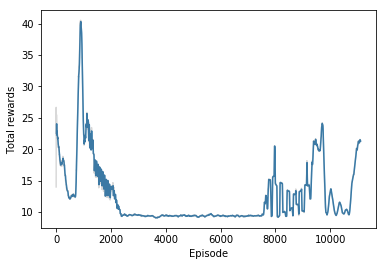

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

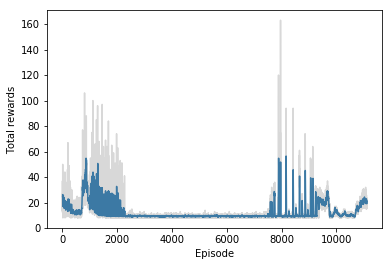

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

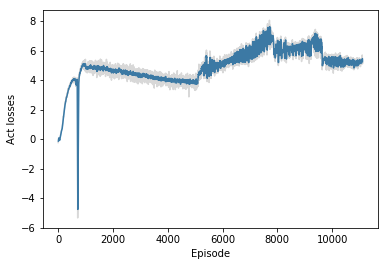

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

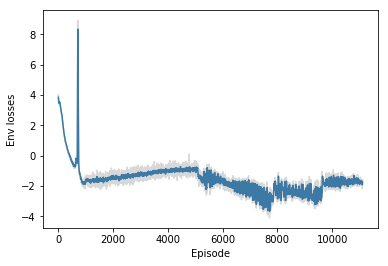

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
